# Ensemble Learning of Catchment-Wise Optimized LSTMs Enhances Regional Rainfall-Runoff modelling

This code is for paper: "Ensemble Learning of Catchment-Wise Optimized LSTMs Enhances Regional Rainfall-Runoff modelling - Case Study: Basque Country, Spain" by Hosseini et al. 2024 (Preprint - under review)

# Overview

        This code outlines a systematic hyperparameter tuning approach using random search and the proposed approach for ensemble learning of optimized LSTMs in regional hydrology, specifically tailored for hydrological prediction using LSTMs. While the example focuses on Multi-Timescale LSTM (MTS-LSTM), the methodology can be adapted for other Deep Learning models.

**Steps**

1. Hyperparameter Space Definition ()
        
        Description: Define the hyperparameters, specifying their ranges and values for simultaneous tuning.
        Details: In this study, 10 hyperparameters with two schedules for learning rate were chosen for tuning, as detailed in the associated paper.

2. Random Search Training and validation

        Description: Execute random searches within the predefined hyperparameter space.
        Details:
        Initial Configuration: 1000 randomly tuned configurations.

        Steps 1 and 2 are the same as a previous paper:
        Hosseini Hossein Abadi, Farzad and Prieto Sierra, Cristina and Álvarez Díaz, Cesar, "Precise Tuning of Regional Hydrological Lstm Networks: Simultaneous Systematic Random Search Optimization."
        Available at SSRN: https://ssrn.com/abstract=4815562 or http://dx.doi.org/10.2139/ssrn.4815562 (Under Review)
        The codes and dataset utilized in that study, along with comprehensive instructions for replicating the experiments, are accessible on our repositories on https://github.com/farzadhoseini/Precise_Tuning_of_Regional_Hydrological_LSTM_Networks and https://doi.org/10.5281/zenodo.11092080.

        Hypertuning folder data can be downloaded from the previous paper: https://doi.org/10.5281/zenodo.13220701
        
        All the steps for designing the hyperparameter space and performing 1000 random searches are the same and from the other paper.
        Here in this new paper, we continue with new steps post-random search. We chose three different ensemble configurations as the following steps present and compared the outcomes after retraining with the best network from the preious paper as the benchmarck.

3. Analysis of validation Metrics (Post-random search validation DATASET)

        Description: Analyze the results to identify optimal hyperparameter configurations.
        Details:
        Post-Random Sraech validation DATASET Structure:
        Configurations: 1000 (594 successful) lines
        Basins: Every configuration results in 25 distinct NSE and KGE metrics for 25 basins with validation data; later we tested final hyper-tuned models' performance on all 40 basins.
        Metrics: KGE and NSE values for each basin
        Analysis Approach:
        Regional Analysis: Averaging metrics across all basins for each configuration for ERO network
        Catchment-scale Analysis: Evaluating each basin individually for Catchment-wise Configs ensemble
        Top 10 Configs Analysis: Averaging metrics across all basins for each configuration to find the top 10 Configs ensemble (ERO was the first)
        K-means Clustering Analysis: Evaluating each basin individually by K-means clustering to find the best Configs ensembles

        We explored different ensemble learning approaches for selecting configurations rather than relying solely on the regionally best-performing configuration (ERO network). Ultimately, we adopted 3 approaches for this purpose:
        1 - Top 10 Configs: We selected the top ten regionally best-performing configurations on the validation set after 1000 random searches; this ensemble included ERO.
        2 - Catchment-wise Configs: Recognizing the uniqueness of the catchments in shaping their hydrological behaviors, we chose the best-performing regional configurations for each catchment individually, regarding its validation metrics. Since validation data was available for only 25 basins, this approach yielded 23 unique configurations, with some overlap in certain cases at the end.
        3 - K-means Configs: To minimize cognitive bias in the configuration selection process, we employed a K-means Clustering (MacQueen, 1967) unsupervised machine learning model. This model was trained on the normalized post-random search validation DATASET to select an ensemble of best-performing regional configurations. After experimenting with different numbers of clusters, we converged on 8 configurations chosen by the K-means Clustering model, representing a cluster with the highest overall average metrics in several tries.

        Outcome: The best-performing configuration was selected based on the highest average NSE and KGE metrics across all 25 basins after both 100 and 1000 random searches.

4. Training the three ensemble learning methods and benchmarking against ERO

        Description: Train the final models identified post-random search.
        Training Runs: Conduct 10 training runs using 10 different random seeds for each selected configuration.
        Generate ensembles' final predictions (medians of predictions by all configurations in every ensemble on every time step on each random seed)
        Outcome: Each method produces an ensemble of 10 predictions, accompanied by their respective metrics for each catchment. This way we could compare the four different approaches.
        Comparisons: we plotted box plots in all basins and also CDFs of the metrics and we performed statistical tests to make sure if predictions by different methods are significantly different.
        

# Steps 1-3 can be found in another code named: "Master_Hypertune_LSTMS_Regional_Hydrological_predictions"

# The previous code was for hyperparameter optimization, finding the best configs and training and testing.

# From now on, we move to step 4 for generating ensemble predictions, benchmarking, evaluation and comparisons.

In [1]:
"""
=================== Import required libraries ===================
"""
import csv
import ast
import yaml
import shutil
import random
import datetime
import matplotlib.colors as mcolors
from matplotlib import colors
from pathlib import Path
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap
from matplotlib.image import imread
import os
import pickle
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.image import imread
from matplotlib.colors import ListedColormap
import warnings
import xarray as xr
from typing import Tuple
from matplotlib.image import imread
from matplotlib.colors import ListedColormap
from scipy.stats import wilcoxon
from scipy.stats import mannwhitneyu
from scipy.stats import f_oneway

import sys
sys.path.append(r'C:\Users\~\neuralhydrology') # In case of using VSC, this can help to activate and run libraries installed
# In our experiments we employed NeuralHydrology Python Library (Kratzert et al., (2022). NeuralHydrology --- A Python library for Deep Learning research in hydrology. 
# Journal of Open Source Software, 7(71), 4050, https://doi.org/10.21105/joss.04050)

from neuralhydrology.nh_run import start_run, Config
from neuralhydrology.evaluation import metrics, get_tester
from neuralhydrology.nh_run_scheduler import schedule_runs
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid, ParameterSampler
from sklearn.metrics import mean_squared_error, r2_score


from neuralhydrology.evaluation.metrics import calculate_metrics
from neuralhydrology.evaluation.metrics import calculate_all_metrics

from sklearn.model_selection import ParameterGrid, ParameterSampler
from neuralhydrology.utils.nh_test_results_ensemble import create_test_results_ensemble


In [1]:
# 01 _ 01 - These variables are used during the experiment by the following codes

# The ten seeds that we trained all models on them. They were chosen randomly one time but then they were fixed for all the models
seeds = [970216, 846266, 931334, 723952, 893856, 339685, 64410, 202981, 105209, 370654]

# Read the basins list from the text file
with open(r'D:\Thesis2024\Papers.OnGoing\Papers.UnderWork\Paper.02.Configuration.Selection.post-Random.Search\Supplementary_materials\Data\URA40basins_list.txt', 'r') as file:
    URA_basins = file.read().splitlines() # This is the list of all 40 basins that their data used to train all models


# Get a list of 25 basins that had verification data from 2000 to 2005 and were considered in the experiment and tests (We considered both streamflow and Water level as targets)
verification_basins = ['Abusu', 'Agauntza', 'Aitzu', 'Aixola', 'Aizarnazabal', 'Alegia', 'Altzola', 'Amorebieta', 'Anarbe', 'Balmaseda',
              'Elorrio', 'Erenozu', 'Estanda', 'Gardea', 'Herrerias', 'Lasarte', 'Leitzaran', 'Muxika', 'Oiartzun', 'Onati', 
              'Otxandio', 'Sangroniz', 'Saratxo', 'Urkizu', 'Zaratamo'] # All of these basins have streamflow records

verification_basins_23 = ['Abusu', 'Agauntza', 'Aitzu', 'Aixola', 'Aizarnazabal', 'Alegia', 'Altzola', 'Anarbe_Herrerias', 'Balmaseda',
              'Elorrio', 'Erenozu', 'Estanda', 'Gardea', 'Lasarte_Amorebieta', 'Leitzaran', 'Muxika', 'Oiartzun', 'Onati', 
              'Otxandio', 'Sangroniz', 'Saratxo', 'Urkizu', 'Zaratamo'] # All of these basins have streamflow records

nolevel_basins      = ['Aitzu', 'Aixola', 'Aizarnazabal', 'Altzola',	'Anarbe', 'Erenozu', 'Leitzaran', 'Oiartzun'] # These basins do not have Water Level data records
URAnolevel_basins   = ['Abetxuko', 'Aitzu', 'Aixola', 'Aizarnazabal', 'Alegria', 'Altzola',	'Anarbe', 'Arenao', 'Erenozu', 'Ibaieder', 'Leitzaran', 'Oiartzun', 'Sodupe'] # These basins do not have Water Level data records


# Get a list of 25 basins that had verification data from 2000 to 2005 and were considered in the experiment and tests (We considered both streamflow and Water level as targets)
all_basins = ['Abusu', 'Agauntza', 'Aitzu', 'Aixola', 'Aizarnazabal', 'Alegia', 'Altzola', 'Amorebieta', 'Anarbe', 'Balmaseda',
              'Elorrio', 'Erenozu', 'Estanda', 'Gardea', 'Herrerias', 'Lasarte', 'Leitzaran', 'Muxika', 'Oiartzun', 'Onati', 
              'Otxandio', 'Sangroniz', 'Saratxo', 'Urkizu', 'Zaratamo'] # All of these basins have streamflow records

# Convert both lists to sets
URA_basins_set = set(URA_basins)
verification_basins_set = set(verification_basins)
nolevel_basins_set = set(nolevel_basins)
URAnolevel_basins_set = set(URAnolevel_basins)
all_basins_set = set(all_basins)

# Obtain the difference (level basins)
level_basins_set    = verification_basins_set - nolevel_basins_set
URAlevel_basins_set = URA_basins_set - URAnolevel_basins_set

# Convert the result back to a list
level_basins = sorted(list(level_basins_set))       # These are 17 basins that have water level records
URAlevel_basins = sorted(list(URAlevel_basins_set)) # These are 30 basins that have water level records
URA_basins = sorted(list(URA_basins_set)) # These are 30 basins that have water level records
all_basins = sorted(list(all_basins_set)) # These are 30 basins that have water level records
verification_basins = sorted(list(verification_basins_set)) # These are 30 basins that have water level records
nolevel_basins = sorted(list(nolevel_basins_set)) # These are 30 basins that have water level records
URAnolevel_basins = sorted(list(URAnolevel_basins_set)) # These are 30 basins that have water level records


# Print or use the result
print('URA_basins:              ', '( are ', len(URA_basins),'   basins):', URA_basins)
print('all_basins:              ', '( are ', len(all_basins),'   basins):', all_basins)
print('verification_basins:     ', '( are ',len(verification_basins),'   basins):', verification_basins)
print('verification_basins_23:  ', '( are ',len(verification_basins_23),'   basins):', verification_basins)
print('level_basins:            ', '( are ', len(level_basins),'   basins):', level_basins)
print('nolevel_basins:          ', '( are ', len(nolevel_basins),'    basins):', nolevel_basins)
print('URAlevel_basins:         ', '( are ', len(URAlevel_basins),'   basins):', URAlevel_basins)
print('URAnolevel_basins:       ', '( are ', len(URAnolevel_basins),'   basins):', URAnolevel_basins)


URA_basins:               ( are  40    basins): ['Abetxuko', 'Abusu', 'Agauntza', 'Aitzu', 'Aixola', 'Aizarnazabal', 'Alegia', 'Alegria', 'Altzola', 'Amorebieta', 'Anarbe', 'Araxes', 'Arenao', 'Areta', 'Balmaseda', 'Eibar', 'Elorrio', 'Erenozu', 'Estanda', 'Etura', 'Gardea', 'Gatika', 'Herrerias', 'Ibaieder', 'Jaizubia', 'Larrainazubi', 'Lasarte', 'Leitzaran', 'Markina', 'Muxika', 'Oiartzun', 'Onati', 'Otxandio', 'Ozaeta', 'SanPrudentzio', 'Sangroniz', 'Saratxo', 'Sodupe', 'Urkizu', 'Zaratamo']
all_basins:               ( are  25    basins): ['Abusu', 'Agauntza', 'Aitzu', 'Aixola', 'Aizarnazabal', 'Alegia', 'Altzola', 'Amorebieta', 'Anarbe', 'Balmaseda', 'Elorrio', 'Erenozu', 'Estanda', 'Gardea', 'Herrerias', 'Lasarte', 'Leitzaran', 'Muxika', 'Oiartzun', 'Onati', 'Otxandio', 'Sangroniz', 'Saratxo', 'Urkizu', 'Zaratamo']
verification_basins:      ( are  25    basins): ['Abusu', 'Agauntza', 'Aitzu', 'Aixola', 'Aizarnazabal', 'Alegia', 'Altzola', 'Amorebieta', 'Anarbe', 'Balmaseda', 'Elor

In [10]:
## 01 _ 02 - These codes are used during the experiment by the following codes

def load_test_results(test_path):
    with open(test_path, 'rb') as file:
        return pickle.load(file)

# Function to read config.yml and extract relevant information
def read_config_yaml(folder_path):
    config_path = os.path.join(folder_path, 'config.yml')

    try:
        with open(config_path, 'r') as config_file:
            config_data = yaml.load(config_file, Loader=yaml.FullLoader)
            seed = config_data.get('seed', 'Unknown')
            return seed
    except Exception as e:
        print(f"Error reading {config_path}: {e}")
        return 'Error', 'Error'


In [94]:
# 02_01 - This code extracts the simulation results for test period by ERO model

"""
=============================== Generate simulations pickle files for ERO ===============================
"""

# 10_1 This code generates pickle files of the simulations of ERO models and save them in:
#       1. ERO_sims_seeds.p (Simulations are for all 40 basins) Each basin has 10 seeds of simulations

# Define a function to calculate and save percentiles for different variables
def calculate_and_save_simulations(parent_dir, basins_list):

    # Initialize results_dict
    results_dict = {}

    # Loop through seeds
    for seed in seeds:
        # Initialize results_dict for each seed if not already initialized
        if seed not in results_dict:
            results_dict[seed] = {'1H': {}, '1D': {}}
        
        # Loop through basins
        for basin in URA_basins:
            # Initialize results_dict for each basin if not already initialized
            if basin not in results_dict[seed]['1H']:
                results_dict[seed]['1H'][basin] = {'qsim': [], 'lsim': []}
            if basin not in results_dict[seed]['1D']:
                results_dict[seed]['1D'][basin] = {'qsim': [], 'lsim': []}

    for folder_name in os.listdir(parent_dir):
        # Find all directories within the 'test' directory
        test_subfolders = [f.path for f in os.scandir(os.path.join(parent_dir, folder_name, 'test')) if f.is_dir()]

        # Pick the first subfolder found (you can modify this logic as needed)
        if test_subfolders:
            first_subfolder = test_subfolders[0]
        else:
            # Handle case where no subfolders are found
            raise ValueError("No subfolders found within 'test' directory")

        # Construct the pickle file path using the first subfolder
        pickle_file_path = os.path.join(folder_name, 'test', first_subfolder, 'test_results.p')
        # Load the data package from the pickle file
        with open(pickle_file_path, 'rb') as f:
            test_results = pickle.load(f)

        folder_path_config = os.path.join(parent_dir, folder_name)
        seed = read_config_yaml(folder_path_config)

        for basin in basins_list:

            # Extract simulations for the current basin
            for intv in ['1H', '1D']:  # Use a different variable name for the inner loop
                for sim in ['streamflowmean_sim', 'levelmean_sim']:
                    if sim == 'streamflowmean_sim': results_dict[seed][intv][basin]['qsim'] = test_results[basin][intv]['xr'][sim].values.flatten() if intv == '1H' else test_results[basin][intv]['xr'][sim].values
                    else: results_dict[seed][intv][basin]['lsim'] = test_results[basin][intv]['xr'][sim].values.flatten() if intv == '1H' else test_results[basin][intv]['xr'][sim].values

    # Save the combined dictionary as a pickle file
    pickle_file_path = rf"...\Supplementary_materials\PickleFiles\ERO_sims_seeds.p"
    with open(pickle_file_path, 'wb') as pickle_file:
        pickle.dump(results_dict, pickle_file)

    print("Data saved successfully.")
# Define the parent directory that contains the folders with config files
parent_dir = r"...\Supplementary_materials\trained_models\ERO_Overfitting_Checked" # overfitting was checked manually by Python Tensorboard after retraining

# Calculate and save 50% percentiles for the specified variables
calculate_and_save_simulations(parent_dir, URA_basins)


Data saved successfully.


In [95]:
# 02_01 - This code loads the simulation results for test period by ERO model

"""
=================== To load ERO Model simulation datapackage ===================
"""

PicklesDataBank_folder = r"...\Supplementary_materials\PickleFiles"

pickle_file_path = os.path.join(PicklesDataBank_folder, 'ERO_sims_seeds' + '.p')
# Load the data package from the pickle file
with open(pickle_file_path, 'rb') as f:
    ERO = pickle.load(f)
print(ERO.keys())
print(ERO[846266].keys())
print(ERO[846266]['1H'].keys())
print(ERO[846266]['1D'].keys())
print(ERO[846266]['1H']['Lasarte'].keys())
print(ERO[846266]['1H']['Lasarte']['qsim'])
print(ERO[846266]['1H']['Lasarte']['lsim'])


dict_keys([970216, 846266, 931334, 723952, 893856, 339685, 64410, 202981, 105209, 370654])
dict_keys(['1H', '1D'])
dict_keys(['Abetxuko', 'Abusu', 'Agauntza', 'Aitzu', 'Aixola', 'Aizarnazabal', 'Alegia', 'Alegria', 'Altzola', 'Amorebieta', 'Anarbe', 'Araxes', 'Arenao', 'Areta', 'Balmaseda', 'Eibar', 'Elorrio', 'Erenozu', 'Estanda', 'Etura', 'Gardea', 'Gatika', 'Herrerias', 'Ibaieder', 'Jaizubia', 'Larrainazubi', 'Lasarte', 'Leitzaran', 'Markina', 'Muxika', 'Oiartzun', 'Onati', 'Otxandio', 'Ozaeta', 'Sangroniz', 'SanPrudentzio', 'Saratxo', 'Sodupe', 'Urkizu', 'Zaratamo'])
dict_keys(['Abetxuko', 'Abusu', 'Agauntza', 'Aitzu', 'Aixola', 'Aizarnazabal', 'Alegia', 'Alegria', 'Altzola', 'Amorebieta', 'Anarbe', 'Araxes', 'Arenao', 'Areta', 'Balmaseda', 'Eibar', 'Elorrio', 'Erenozu', 'Estanda', 'Etura', 'Gardea', 'Gatika', 'Herrerias', 'Ibaieder', 'Jaizubia', 'Larrainazubi', 'Lasarte', 'Leitzaran', 'Markina', 'Muxika', 'Oiartzun', 'Onati', 'Otxandio', 'Ozaeta', 'Sangroniz', 'SanPrudentzio', 'Sa

In [96]:
# 02_02 - This code extracts the simulation results for test period by different ensemble learning models

"""
=============================== Generate simulations pickle files for different ensemble learning methods ===============================
"""

# 10_1 This code generates pickle files of the simulations 

# Define a function to calculate and save percentiles for different variables
def calculate_and_save_percentiles(parent_dir, basins_list, pickle_name):

    # Initialize results_dict
    results_dict = {}

    # Loop through seeds
    for seed in seeds:
        # Initialize results_dict for each seed if not already initialized
        if seed not in results_dict:
            results_dict[seed] = {}
            
    for folder_name in os.listdir(parent_dir):
        # Find all directories within the 'test' directory
        test_subfolder = [f.path for f in os.scandir(os.path.join(parent_dir, folder_name, 'test')) if f.is_dir()]

        # Construct the pickle file path using the first subfolder
        pickle_file_path = os.path.join(*test_subfolder, 'test_results.p')
        # Load the data package from the pickle file
        with open(pickle_file_path, 'rb') as f:
            test_results = pickle.load(f)

        folder_path_config = os.path.join(parent_dir, folder_name)
        seed = read_config_yaml(folder_path_config)

        # Loop through seeds
        if folder_name not in results_dict[seed]:
            results_dict[seed][folder_name] = {'1H': {}, '1D': {}}
                
            # Loop through basins
            for basin in URA_basins:
                # Initialize results_dict for each basin if not already initialized
                for interval in ['1H', '1D']:
                    if basin not in results_dict[seed][folder_name][interval]:
                        results_dict[seed][folder_name][interval][basin] = {'qsim': [], 'lsim': []}
                    if basin not in results_dict[seed][folder_name][interval]:
                        results_dict[seed][folder_name][interval][basin] = {'qsim': [], 'lsim': []}

        for basin in basins_list:

            # Extract simulations for the current basin
            for intv in ['1H', '1D']:  # Use a different variable name for the inner loop
                for sim in ['streamflowmean_sim', 'levelmean_sim']:
                    if sim == 'streamflowmean_sim': results_dict[seed][folder_name][intv][basin]['qsim'] = test_results[basin][intv]['xr'][sim].values.flatten() if intv == '1H' else test_results[basin][intv]['xr'][sim].values
                    else: results_dict[seed][folder_name][intv][basin]['lsim'] = test_results[basin][intv]['xr'][sim].values.flatten() if intv == '1H' else test_results[basin][intv]['xr'][sim].values

    # Save the combined dictionary as a pickle file
    pickle_file_path = rf"...\Supplementary_materials\PickleFiles\{pickle_name}.p"
    with open(pickle_file_path, 'wb') as pickle_file:
        pickle.dump(results_dict, pickle_file)

    print("Data saved successfully.")




In [97]:
# 02_02_01 - This code extracts the simulation results for test period by K-means Configs ensemble learning model

"""
=============================== Generate simulations pickle files for K-means Configs ensemble ===============================
"""

# 10_1 This code generates pickle files of the simulations of 80 K-means Configs models and save them in:
#       1. K_means_Configs_80_sims_seeds.p (Simulations are for all 40 basins) Each basin has 10 seeds of simulations

# Define the parent directory that contains the folders with config files
parent_dir = r"...\Supplementary_materials\trained_models\K_means_Configs_Overfitting_Checked" # overfitting was checked manually by Python Tensorboard after retraining
pickle_name = 'K_means_Configs_80_sims_seeds'
# Calculate and save 50% percentiles for the specified variables
calculate_and_save_percentiles(parent_dir, URA_basins, pickle_name)


Data saved successfully.


In [100]:
# 02_02_02 - This code extracts the simulation results for test period by Top 10 Configs ensemble learning models

"""
=============================== Generate simulations pickle files for Top 10 Configs ensemble ===============================
"""

# 10_1 This code generates pickle files of the simulations of 94 Top 10 Configs models and save them in:
#       1. Top_10_Configs_94_sims_seeds.p (Simulations are for all 40 basins) Each basin has 10 seeds of simulations

# Define the parent directory that contains the folders with config files
parent_dir = r"...\Supplementary_materials\trained_models\Top10Configs_Overfitting_Checked" # overfitting was checked manually by Python Tensorboard after retraining
pickle_name = 'Top_10_Configs_94_sims_seeds'

# Calculate and save 50% percentiles for the specified variables
calculate_and_save_percentiles(parent_dir, URA_basins, pickle_name)


Data saved successfully.


In [102]:
# 02_02_03 - This code extracts the simulation results for test period by Catchment-Wise Configs ensemble learning models

"""
=============================== Generate simulations pickle files for Catchment-Wise Configs ensemble ===============================
"""

# 10_1 This code generates pickle files of the simulations of 230 Catchment-Wise Configs models and save them in:
#       1. Catchment_Wise_Configs_230_sims_seeds.p (Simulations are for all 40 basins) Each basin has 10 seeds of simulations

# Define the parent directory that contains the folders with config files
parent_dir = r"...\Supplementary_materials\trained_models\Catchment_Wise_Configs" # All models after 50 epochs of training were taken
pickle_name = 'Catchment_Wise_Configs_230_sims_seeds'

# Calculate and save 50% percentiles for the specified variables
calculate_and_save_percentiles(parent_dir, URA_basins, pickle_name)


Data saved successfully.


In [104]:
# 03_01 - This code generates final simulation results for the ensemble learning models

"""
=============================== Generate simulations' percentiles pickle files ===============================
"""

# 11_1 Code to generate 95%, 50% (median) percentiles and save them in a pickle file for all trained mdoels' simulations on the ten different seeds
#       1. K_means_Configs_80_sims_seeds.p (3 sets of 5%, 50% (median), and 95% percentiles for all 40 basins) Generated form the 80 simulations on 10 different seeds
#       2. Top_10_Configs_94_sims_seeds.p (3 sets of 5%, 50% (median), and 95% percentiles for all 40 basins) Generated form the 94 simulations on 10 different seeds
#       3. Catchment_Wise_Configs_230_sims_seeds.p (3 sets of 5%, 50% (median), and 95% percentiles for 40 basins) Generated form the 230 simulations on 10 different seeds

# Function to save percentiles from pickle files
def save_percentiles_from_pickle(directory, percentiles, models):
    for model in models:
        # Initialize dictionary to store percentile data
        sims_percentiles = {}
        
        # Load the pickle file containing basin-configured simulations
        pickle_file_path = os.path.join(directory, f"{model}.p")
        with open(pickle_file_path, 'rb') as pickle_file:
            sims_loaded = pickle.load(pickle_file)
        
        for seed in seeds:
            if seed not in sims_percentiles:  # Check if seed is not in sims_percentiles
                sims_percentiles[seed] = {'1H': {}, '1D': {}}
            for interval in ['1H', '1D']:
                for basin in URA_basins:
                    if basin not in sims_percentiles[seed][interval]:
                        sims_percentiles[seed][interval][basin] = {'qsim': {}, 'lsim': {}}
                        for variable in ['qsim', 'lsim']:
                            all_variable_data = []
                            for folder_name in sims_loaded[seed].keys():
                                all_variable_data.append(sims_loaded[seed][folder_name][interval][basin][variable])

                            # Stack the arrays in all_variable_data along a new axis
                            stacked_data = np.stack(all_variable_data, axis=1)

                            # Calculate percentiles
                            variable_percentiles = np.percentile(stacked_data, percentiles, axis=1).T
                            
                            # Define column names based on percentiles
                            column_names = [f"{percentile}% percentile" for percentile in percentiles]

                            # Reshape percentiles_values to make it 2D
                            variable_percentiles = variable_percentiles.reshape(-1, len(percentiles))

                            # Create a DataFrame to store percentiles with appropriate column names
                            variable_percentiles = pd.DataFrame(variable_percentiles, columns=column_names)
                            sims_percentiles[seed][interval][basin][variable] = variable_percentiles
        # Save the combined dictionary as a pickle file
        pickle_file_path = os.path.join(directory, f"{model}_percentiles.p")
        with open(pickle_file_path, 'wb') as pickle_file:
            pickle.dump(sims_percentiles, pickle_file)
        
        print(f"Percentiles saved successfully for {model}.")

# Define the output directory where the pickle files will be saved
directory = r"...\Supplementary_materials\PickleFiles"

models = ['K_means_Configs_80_sims_seeds', 'Top_10_Configs_94_sims_seeds', 'Catchment_Wise_Configs_230_sims_seeds']

# Define the percentiles to calculate
percentiles =[5, 50, 95]

# Save percentiles from the loaded pickle file
save_percentiles_from_pickle(directory, percentiles, models)


Percentiles saved successfully for K_means_Configs_80_sims_seeds.
Percentiles saved successfully for Top_10_Configs_94_sims_seeds.
Percentiles saved successfully for Catchment_Wise_Configs_230_sims_seeds.


In [ ]:
# 03 _ 02 - This code loads all pickle files that will be used by the following codes

pickle_file_path1 = r"...\Supplementary_materials\PickleFiles\ERO_sims_seeds.p"                                       # 10 seeds for ERO
pickle_file_path3 = r"...\Supplementary_materials\PickleFiles\Catchment_Wise_Configs_230_sims_seeds_percentiles.p"    # 10 seeds for Catchment_Wise_Configs
pickle_file_path5 = r"...\Supplementary_materials\PickleFiles\K_means_Configs_80_sims_seeds_percentiles.p"            # 10 seeds for K_means_Configs
pickle_file_path7 = r"...\Supplementary_materials\PickleFiles\Top_10_Configs_94_sims_seeds_percentiles.p"             # 10 seeds for Top_10_Configs
pickle_file_path_obs = r"...\Supplementary_materials\PickleFiles\data_package_obs.p"                                  # Test set Observatoions Pickle file

with open(pickle_file_path1, 'rb') as pickle_file:
    Enhanced_Regional_Optimal_ERO = pickle.load(pickle_file)
with open(pickle_file_path3, 'rb') as pickle_file:
    Catchment_Wise_Configs = pickle.load(pickle_file)
with open(pickle_file_path5, 'rb') as pickle_file:
    K_means_Configs = pickle.load(pickle_file)
with open(pickle_file_path7, 'rb') as pickle_file:
    Top_10_Configs = pickle.load(pickle_file)
with open(pickle_file_path_obs, 'rb') as pickle_file:
    Obs_loaded = pickle.load(pickle_file)


In [111]:
# 04_01 To calculate all metrics for all four 50% percentiles (median) simulations loaded
# We are going to calculate The following metrics for all four 50% percentiles (median) simulations of different ensemble learning model types

metrics = ["NSE", "MSE", "RMSE", "KGE", "Alpha-NSE", "Pearson-r", "Beta-KGE", "Beta-NSE", "FHV", "FMS", "FLV", "Peak-Timing", "Missed-Peaks", "Peak-MAPE"]

model_types = [
   ("Catchment_Wise_Configs_230_sims_seeds", Catchment_Wise_Configs),
   ("K_means_Configs_80_sims_seeds", K_means_Configs),
   ("Top_10_Configs_94_sims_seeds", Top_10_Configs)
]

def Calculate_and_save_metrics(model_type):

    # Unpack the tuple to access both the name and the data
    name, Data = model_type
    Basins = URA_basins
    metrics_results = {seed: {'1H': {basin: {} for basin in Basins}, '1D': {basin: {} for basin in Basins}} for seed in seeds}

    for basin in Basins:

        hr = 52608
        d  = 2192

        if basin == 'Abetxuko':
            hr = 33192
            d  = 1382   
        if basin == 'Aixola':
            hr = 35064
            d  = 1460   
        if basin == 'Alegia':
            hr = 43873
            d  = 1827   
        if basin == 'Alegria':
            hr = 46956
            d  = 1956   
        if basin == 'Amorebieta':
            hr = 47497
            d  = 1979   
        if basin == 'Arenao':
            hr = 43152
            d  = 1797   
        if basin == 'Larrainazubi':
            hr = 47497
            d  = 1979   
        if basin == 'Markina':
            hr = 46081
            d  = 1920   
        if basin == 'Oiartzun':
            hr = 43848
            d  = 1826   
        if basin == 'Sodupe':
            hr = 47397
            d  = 1974   

        for seed in seeds:
            qsim_mean_hr_data, qsim_mean_d_data = [], []
            lsim_mean_hr_data, lsim_mean_d_data = [], []
            qobs_mean_hr_data, qobs_mean_d_data = [], []
            lobs_mean_hr_data, lobs_mean_d_data = [], []

            date_hr = Obs_loaded[basin]['obs_hourly_timestamp']['date'][:hr].to_numpy()
            date_d = Obs_loaded[basin]['obs_daily_timestamp']['date'][:d].to_numpy()
            data = Data[seed]['1H'][basin]['qsim']['50% percentile'][:hr].to_numpy()
            qsim_mean_hr = xr.DataArray(data, coords={"time": date_hr})
            data = Data[seed]['1H'][basin]['lsim']['50% percentile'][:hr].to_numpy()
            lsim_mean_hr = xr.DataArray(data, coords={"time": date_hr})
            data = Data[seed]['1D'][basin]['qsim']['50% percentile'][:d].to_numpy() * 24
            qsim_mean_d = xr.DataArray(data, coords={"time": date_d})
            data = Data[seed]['1D'][basin]['lsim']['50% percentile'][:d].to_numpy() * 24
            lsim_mean_d = xr.DataArray(data, coords={"time": date_d})
            data = Obs_loaded[basin]['qobs_mean_hr'][:hr].to_numpy()
            qobs_mean_hr = xr.DataArray(data[:, 0], coords={"time": date_hr})
            data = Obs_loaded[basin]['lobs_mean_hr'][:hr].to_numpy()
            lobs_mean_hr = xr.DataArray(data[:, 0], coords={"time": date_hr})
            data = Obs_loaded[basin]['qobs_mean_d'][:d].to_numpy()
            qobs_mean_d = xr.DataArray(data[:, 0], coords={"time": date_d})
            data = Obs_loaded[basin]['lobs_mean_d'][:d].to_numpy()
            lobs_mean_d = xr.DataArray(data[:, 0], coords={"time": date_d})

            # Convert numpy datetime values to pandas.Timestamp
            hr_datetime = pd.to_datetime(qobs_mean_hr.time.values)
            d_datetime = pd.to_datetime(qobs_mean_d.time.values)

            # Create DataArrays with pandas.Timestamp
            qsim_mean_hr_data = xr.DataArray(qsim_mean_hr.values, coords={"time": hr_datetime})
            qsim_mean_d_data  = xr.DataArray(qsim_mean_d.values, coords={"time": d_datetime})
            qobs_mean_hr_data = xr.DataArray(qobs_mean_hr.values, coords={"time": hr_datetime})
            qobs_mean_d_data  = xr.DataArray(qobs_mean_d.values, coords={"time": d_datetime})

            lsim_mean_hr_data = xr.DataArray(lsim_mean_hr.values, coords={"time": hr_datetime})
            lsim_mean_d_data  = xr.DataArray(lsim_mean_d.values, coords={"time": d_datetime})
            lobs_mean_hr_data = xr.DataArray(lobs_mean_hr.values, coords={"time": hr_datetime})
            lobs_mean_d_data  = xr.DataArray(lobs_mean_d.values, coords={"time": d_datetime})

            # Calculate all metrics for each basin
            metrics_results[seed]['1H'][basin]['qmean']  = calculate_metrics(qobs_mean_hr_data, qsim_mean_hr_data, metrics, resolution="1H", datetime_coord="time")
            metrics_results[seed]['1D'][basin]['qmean']  = calculate_metrics(qobs_mean_d_data, qsim_mean_d_data, metrics, resolution="1D", datetime_coord="time")
            metrics_results[seed]['1H'][basin]['lmean']  = calculate_metrics(lobs_mean_hr_data, lsim_mean_hr_data, metrics, resolution="1H", datetime_coord="time")
            metrics_results[seed]['1D'][basin]['lmean']  = calculate_metrics(lobs_mean_d_data, lsim_mean_d_data, metrics, resolution="1D", datetime_coord="time")

    # Save the dictionary as a pickle file
    pickle_file_path = rf"...\Supplementary_materials\PickleFiles\{name}_metrics.p"
    with open(pickle_file_path, 'wb') as pickle_file:
        pickle.dump(metrics_results, pickle_file)

    print(f"Metrics pickle file for {name} saved successfully.")

# Suppress ConstantInputWarning and RuntimeWarning
warnings.filterwarnings("ignore", category=RuntimeWarning, module="scipy.stats")
warnings.filterwarnings("ignore", category=RuntimeWarning, module="neuralhydrology.evaluation.metrics")

for model_type in model_types:
    Calculate_and_save_metrics(model_type)


Metrics pickle file for Catchment_Wise_Configs_230_sims_seeds saved successfully.
Metrics pickle file for K_means_Configs_80_sims_seeds saved successfully.
Metrics pickle file for Top_10_Configs_94_sims_seeds saved successfully.


In [115]:
# 04_02 To calculate all metrics for ERO simulations
# The results will be used to benchmark other three ensemble learning approaches

metrics = ["NSE", "MSE", "RMSE", "KGE", "Alpha-NSE", "Pearson-r", "Beta-KGE", "Beta-NSE", "FHV", "FMS", "FLV", "Peak-Timing", "Missed-Peaks", "Peak-MAPE"]

model_types = [
   ("ERO_sims_seeds", ERO)
]

def Calculate_and_save_metrics(model_type):

    # Unpack the tuple to access both the name and the data
    name, Data = model_type
    Basins = URA_basins
    metrics_results = {seed: {'1H': {basin: {} for basin in Basins}, '1D': {basin: {} for basin in Basins}} for seed in seeds}

    for basin in Basins:

        hr = 52608
        d  = 2192

        if basin == 'Abetxuko':
            hr = 33192
            d  = 1382   # 1382.9
        if basin == 'Aixola':
            hr = 35064
            d  = 1460   # 1460.9
        if basin == 'Alegia':
            hr = 43873
            d  = 1827   # 1827.9
        if basin == 'Alegria':
            hr = 46956
            d  = 1956   # 1956.4
        if basin == 'Amorebieta':
            hr = 47497
            d  = 1979   # 1979.01
        if basin == 'Arenao':
            hr = 43152
            d  = 1797   # 1797.9
        if basin == 'Larrainazubi':
            hr = 47497
            d  = 1979   # 1979.04
        if basin == 'Markina':
            hr = 46081
            d  = 1920   # 1920.04
        if basin == 'Oiartzun':
            hr = 43848
            d  = 1826   # 1826.9
        if basin == 'Sodupe':
            hr = 47397
            d  = 1974   # 1974.79

        for seed in seeds:
            qsim_mean_hr_data = []
            lsim_mean_hr_data = []
            qobs_mean_hr_data = []
            lobs_mean_hr_data = []

            date_hr = Obs_loaded[basin]['obs_hourly_timestamp']['date'][:hr].to_numpy()
            data = Data[seed]['1H'][basin]['qsim'][:hr]
            qsim_mean_hr = xr.DataArray(data, coords={"time": date_hr})
            data = Data[seed]['1H'][basin]['lsim'][:hr]
            lsim_mean_hr = xr.DataArray(data, coords={"time": date_hr})
            data = Obs_loaded[basin]['qobs_mean_hr'][:hr].to_numpy()
            qobs_mean_hr = xr.DataArray(data[:, 0], coords={"time": date_hr})
            data = Obs_loaded[basin]['lobs_mean_hr'][:hr].to_numpy()
            lobs_mean_hr = xr.DataArray(data[:, 0], coords={"time": date_hr})

            # Convert numpy datetime values to pandas.Timestamp
            hr_datetime = pd.to_datetime(qobs_mean_hr.time.values)

            # Create DataArrays with pandas.Timestamp
            qsim_mean_hr_data = xr.DataArray(qsim_mean_hr.values, coords={"time": hr_datetime})
            qobs_mean_hr_data = xr.DataArray(qobs_mean_hr.values, coords={"time": hr_datetime})

            lsim_mean_hr_data = xr.DataArray(lsim_mean_hr.values, coords={"time": hr_datetime})
            lobs_mean_hr_data = xr.DataArray(lobs_mean_hr.values, coords={"time": hr_datetime})

            # Calculate all metrics for each basin
            metrics_results[seed]['1H'][basin]['qmean']  = calculate_metrics(qobs_mean_hr_data, qsim_mean_hr_data, metrics, resolution="1H", datetime_coord="time")
            metrics_results[seed]['1H'][basin]['lmean']  = calculate_metrics(lobs_mean_hr_data, lsim_mean_hr_data, metrics, resolution="1H", datetime_coord="time")

    # Save the dictionary as a pickle file
    pickle_file_path = rf"...\Supplementary_materials\PickleFiles\{name}_metrics.p"
    with open(pickle_file_path, 'wb') as pickle_file:
        pickle.dump(metrics_results, pickle_file)

    print(f"Metrics pickle file for {name} saved successfully.")

# Suppress ConstantInputWarning and RuntimeWarning
warnings.filterwarnings("ignore", category=RuntimeWarning, module="scipy.stats")
warnings.filterwarnings("ignore", category=RuntimeWarning, module="neuralhydrology.evaluation.metrics")

for model_type in model_types:
    Calculate_and_save_metrics(model_type)


Metrics pickle file for ERO_sims_seeds saved successfully.


In [ ]:
# 04_03 To load the final metrics for all 4 methods

"""
=================== To load final simulation percentiles datapackages ===================
"""

PicklesDataBank_folder = r"...\Supplementary_materials\PickleFiles"

pickle_file_path = os.path.join(PicklesDataBank_folder, 'K_means_Configs_80_sims_seeds_metrics' + '.p')
# Load the data package from the pickle file
with open(pickle_file_path, 'rb') as f:
    K_means_Configs = pickle.load(f)

pickle_file_path = os.path.join(PicklesDataBank_folder, 'Top_10_Configs_94_sims_seeds_metrics' + '.p')
# Load the data package from the pickle file
with open(pickle_file_path, 'rb') as f:
    Top_10_Configs = pickle.load(f)

pickle_file_path = os.path.join(PicklesDataBank_folder, 'Catchment_Wise_Configs_230_sims_seeds_metrics' + '.p')
# Load the data package from the pickle file
with open(pickle_file_path, 'rb') as f:
    Catchment_Wise_Configs = pickle.load(f)

pickle_file_path = os.path.join(PicklesDataBank_folder, 'ERO_sims_seeds_metrics' + '.p')
# Load the data package from the pickle file
with open(pickle_file_path, 'rb') as f:
    ERO_Config = pickle.load(f)


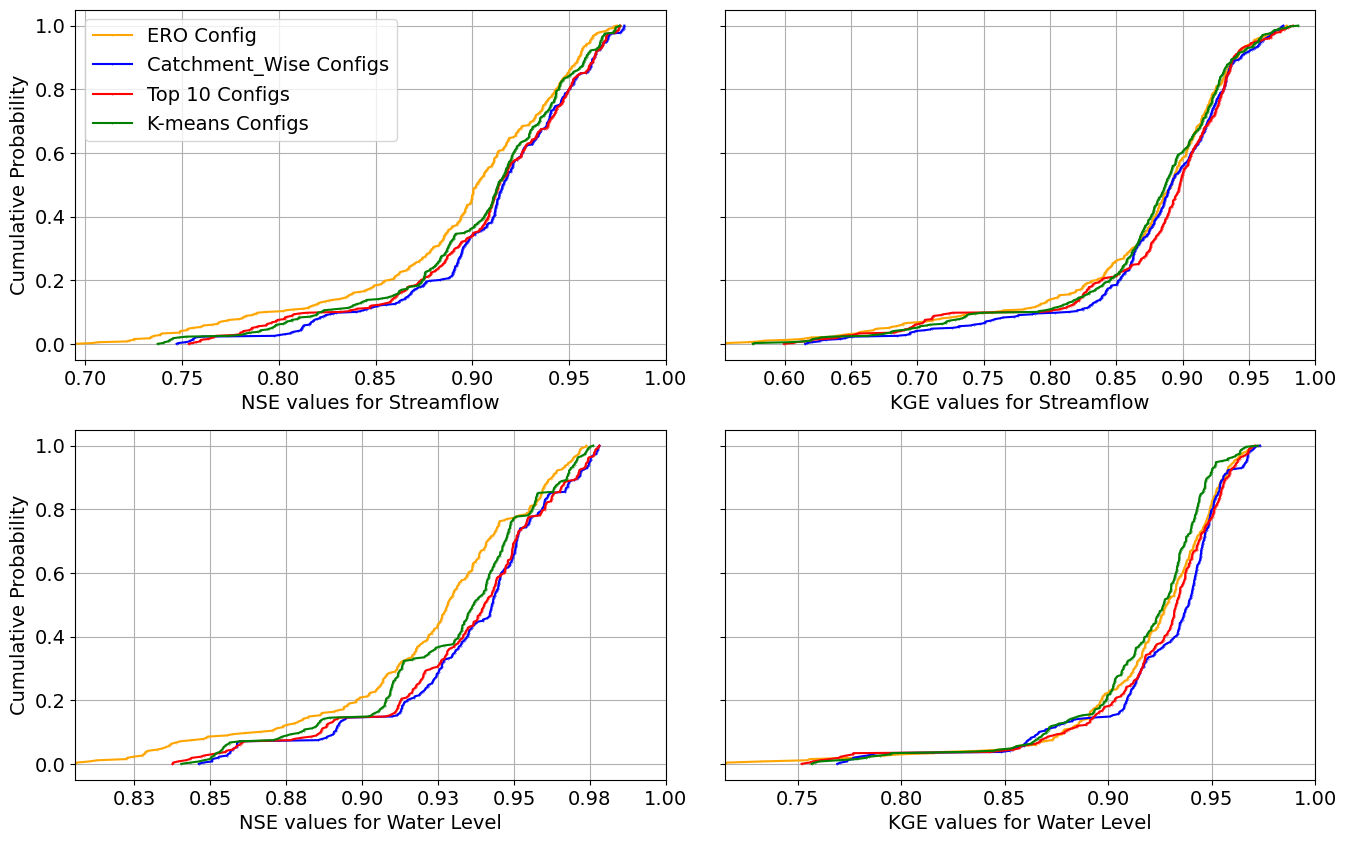

In [117]:
## 05_01 - Benchmarking ensemble learning methods against ERO network (Figure 03)

from matplotlib.ticker import FormatStrFormatter

sims = ['qmean', 'lmean']
metrics_dicts = ['NSE', 'KGE']

def plot_cdf(ax, data, label, color):
    sorted_data = np.sort(data)
    yvals = np.arange(len(sorted_data)) / float(len(sorted_data) - 1)
    ax.plot(sorted_data, yvals, linestyle='-', marker='.', markersize=0.5, label=label, color=color)

# Define the directory to save the plots
save_dir = r"...\Supplementary_materials\Figures"

def create_overall_cdf_plots(metrics_dicts, sims):

    fig, axes = plt.subplots(2, 2, figsize=(16, 10), sharex=False, sharey=True)
    # suptitle = fig.suptitle(f'Benchmarking performance metrics of three ensemble learning approaches versus ERO predictions', y=0.95, fontsize=16)

    plt.subplots_adjust(wspace=0.1, hspace=0.2)  # Decrease wspace for narrower gaps between columns

    # Flatten the 2D array of subplots
    axes = axes.flatten()

    for metric_key in metrics_dicts:
        for sim in sims:
            if sim == 'qmean':
                basins_list = URA_basins
                var = 'Streamflow'
            else:
                basins_list = URAlevel_basins
                var = 'Water Level'

            # Initialize lists for cumulative CDFs
            ERO_configured_list = []
            Top_10_configured_list = []
            K_means_configured_list = []
            Catchment_Wise_configured_list = []

            for seed in seeds:
                for basin in basins_list:
                    ERO_configured = ERO_Config[seed]['1H'][basin][sim][metric_key]
                    Top_10_configured = Top_10_Configs[seed]['1H'][basin][sim][metric_key]
                    K_means_configured = K_means_Configs[seed]['1H'][basin][sim][metric_key]
                    Catchment_Wise_configured = Catchment_Wise_Configs[seed]['1H'][basin][sim][metric_key]

                    ERO_configured_list.extend([ERO_configured])
                    Top_10_configured_list.extend([Top_10_configured])
                    K_means_configured_list.extend([K_means_configured])
                    Catchment_Wise_configured_list.extend([Catchment_Wise_configured])

            if metric_key == 'NSE':
                if sim == 'qmean':
                    ax_index = 0
                else:
                    ax_index = 2
            else:  # 'KGE'
                if sim == 'qmean':
                    ax_index = 1
                else:
                    ax_index = 3

            ax = axes[ax_index]

            plot_cdf(ax, ERO_configured_list, f'ERO Config - {sim}', 'orange')
            plot_cdf(ax, Catchment_Wise_configured_list, f'Catchment_Wise Configs - {sim}', 'blue')
            plot_cdf(ax, Top_10_configured_list, f'Top 10 Configs - {sim}', 'red')
            plot_cdf(ax, K_means_configured_list, f'K-means Configs - {sim}', 'green')

            # Customize the plot
            ax.set_xlabel(f'{metric_key} values for {var}', fontsize=14)
            if ax_index == 0 or ax_index == 2:
                ax.set_ylabel('Cumulative Probability', fontsize=14)
            if ax_index == 0:
                handles, labels = ax.get_legend_handles_labels()
                new_labels = [label.split(" - ")[0] for label in labels]
                ax.legend(handles, new_labels, fontsize=14)
            ax.grid(True)

            # Limit x-axis values
            x_min = min(min(ERO_configured_list), min(Top_10_configured_list), min(K_means_configured_list), min(Catchment_Wise_configured_list))
            ax.set_xlim(x_min, 1)

            # Format x-axis labels
            ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
            ax.tick_params(axis='both', which='major', labelsize=14)
  
    save_path = os.path.join(save_dir, f'Figure03.jpg')
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path, dpi=600)

    # Save the plot to a file
    save_path = os.path.join(save_dir, 'Figure03.pdf')
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path, format='pdf', dpi=600)

    plt.show()

# Call the function
create_overall_cdf_plots(metrics_dicts, sims)


In [118]:
# 06 _ 01 - This code loads all pickle files that will be used by the following codes

pickle_file_path1 = r"...\Supplementary_materials\PickleFiles\ERO_sims_seeds.p"                                       # 10 seeds for ERO
pickle_file_path2 = r"...\Supplementary_materials\PickleFiles\ERO_sims_seeds_metrics.p"                               # 10 seeds metrics for ERO
pickle_file_path3 = r"...\Supplementary_materials\PickleFiles\Catchment_Wise_Configs_230_sims_seeds_percentiles.p"    # 10 seeds for Catchment_Wise_Configs
pickle_file_path4 = r"...\Supplementary_materials\PickleFiles\Catchment_Wise_Configs_230_sims_seeds_metrics.p"        # 10 seeds metrics for Catchment_Wise_Configs
pickle_file_path5 = r"...\Supplementary_materials\PickleFiles\K_means_Configs_80_sims_seeds_percentiles.p"            # 10 seeds for K_means_Configs
pickle_file_path6 = r"...\Supplementary_materials\PickleFiles\K_means_Configs_80_sims_seeds_metrics.p"                # 10 seeds metrics for K_means_Configs
pickle_file_path7 = r"...\Supplementary_materials\PickleFiles\Top_10_Configs_94_sims_seeds_percentiles.p"             # 10 seeds for Top_10_Configs
pickle_file_path8 = r"...\Supplementary_materials\PickleFiles\Top_10_Configs_94_sims_seeds_metrics.p"                 # 10 seeds metrics for Top_10_Configs
pickle_file_path_obs = r"...\Supplementary_materials\PickleFiles\data_package_obs.p"                                  # Test set Observatoions Pickle file

with open(pickle_file_path1, 'rb') as pickle_file:
    Enhanced_Regional_Optimal_ERO = pickle.load(pickle_file)
with open(pickle_file_path2, 'rb') as pickle_file:
    Enhanced_Regional_Optimal_ERO_metrics = pickle.load(pickle_file)
with open(pickle_file_path3, 'rb') as pickle_file:
    Catchment_Wise_Configs = pickle.load(pickle_file)
with open(pickle_file_path4, 'rb') as pickle_file:
    Catchment_Wise_Configs_metrics = pickle.load(pickle_file)
with open(pickle_file_path5, 'rb') as pickle_file:
    K_means_Configs = pickle.load(pickle_file)
with open(pickle_file_path6, 'rb') as pickle_file:
    K_means_Configs_metrics = pickle.load(pickle_file)
with open(pickle_file_path7, 'rb') as pickle_file:
    Top_10_Configs = pickle.load(pickle_file)
with open(pickle_file_path8, 'rb') as pickle_file:
    Top_10_Configs_metrics = pickle.load(pickle_file)
with open(pickle_file_path_obs, 'rb') as pickle_file:
    Obs_loaded = pickle.load(pickle_file)


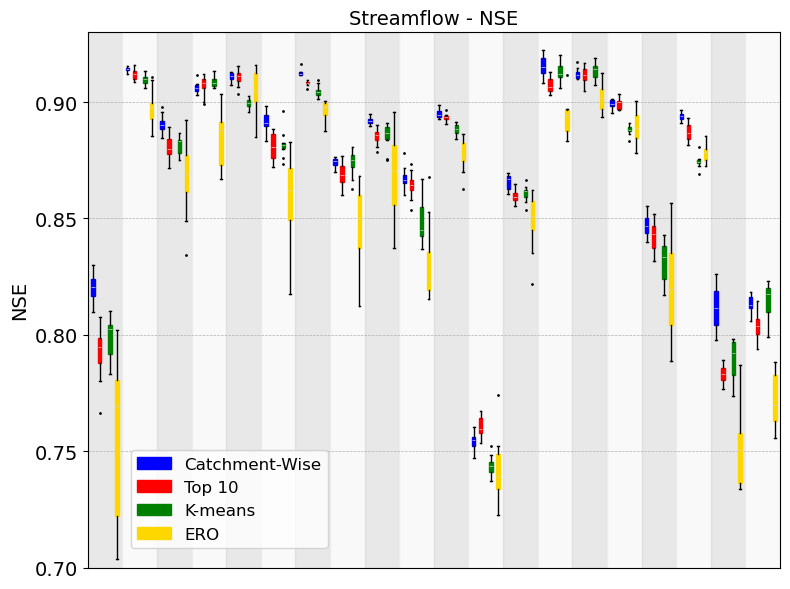

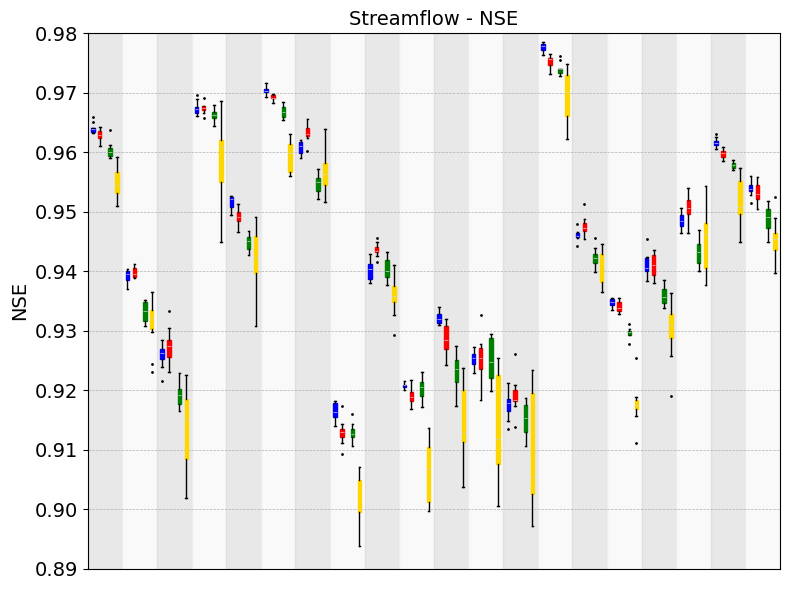

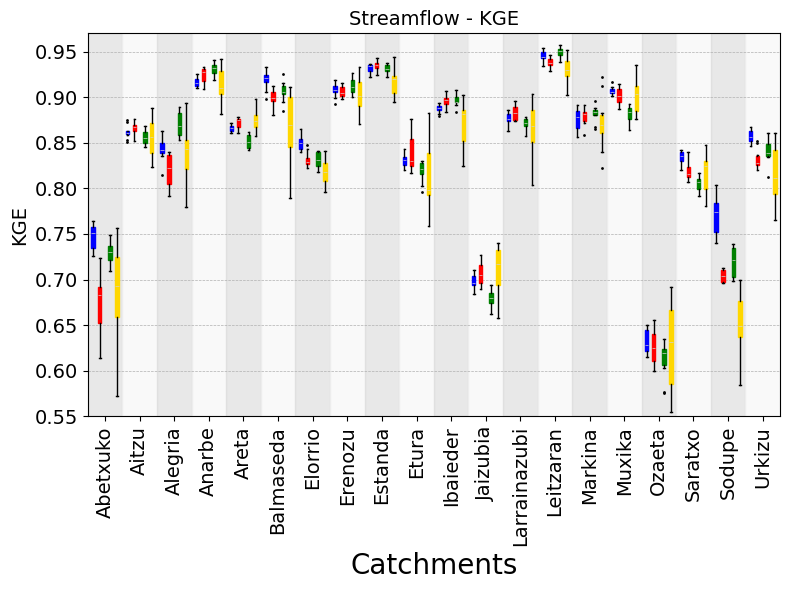

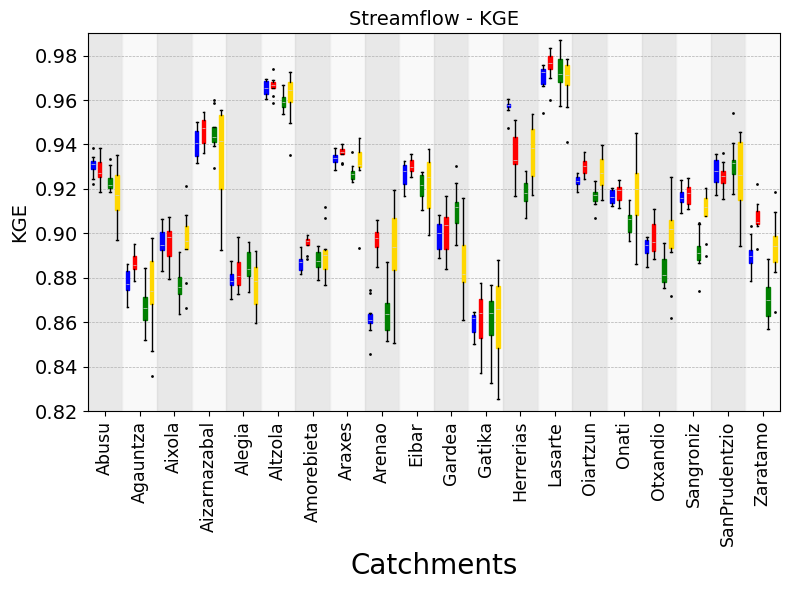

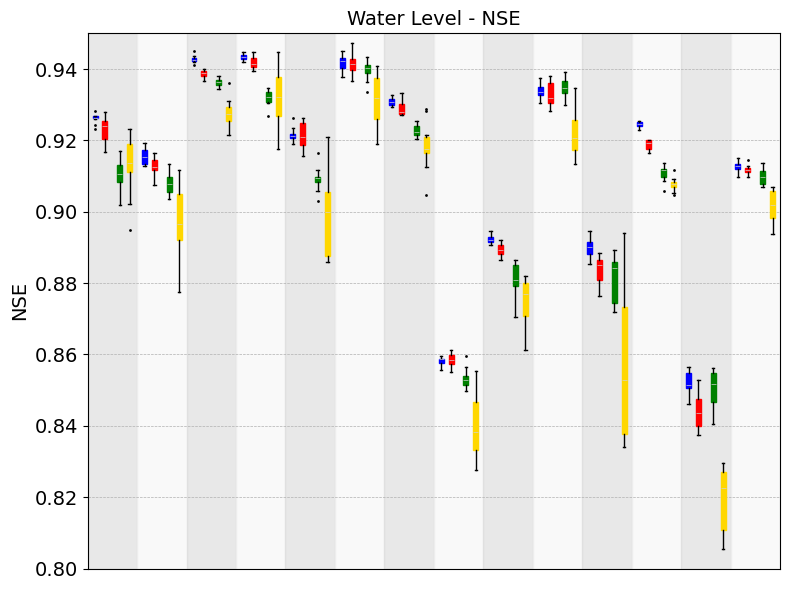

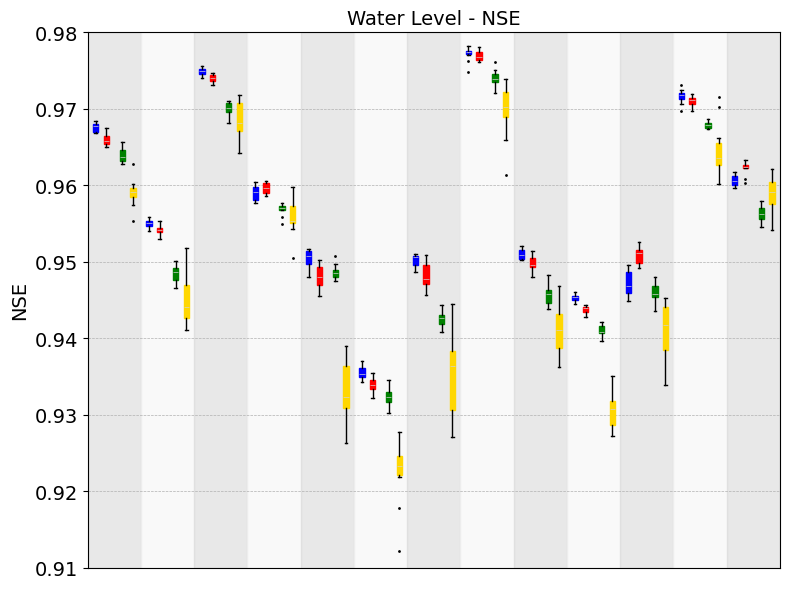

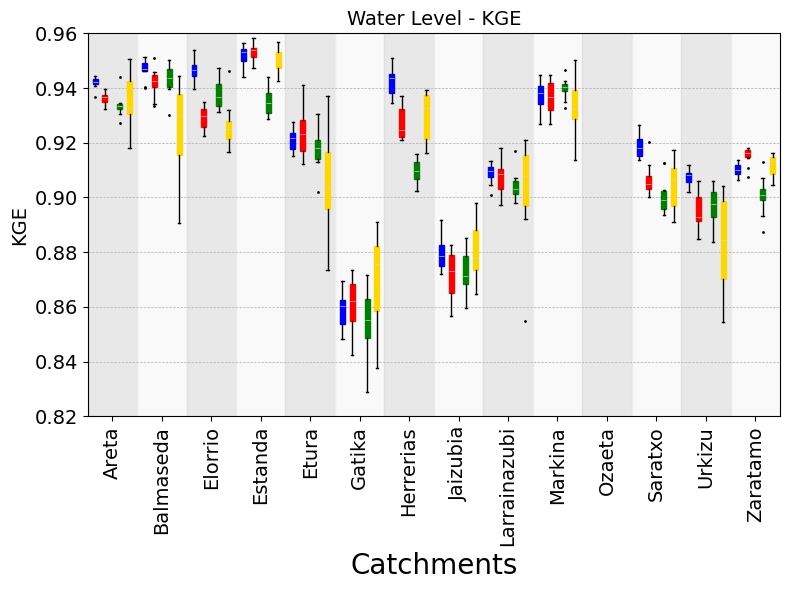

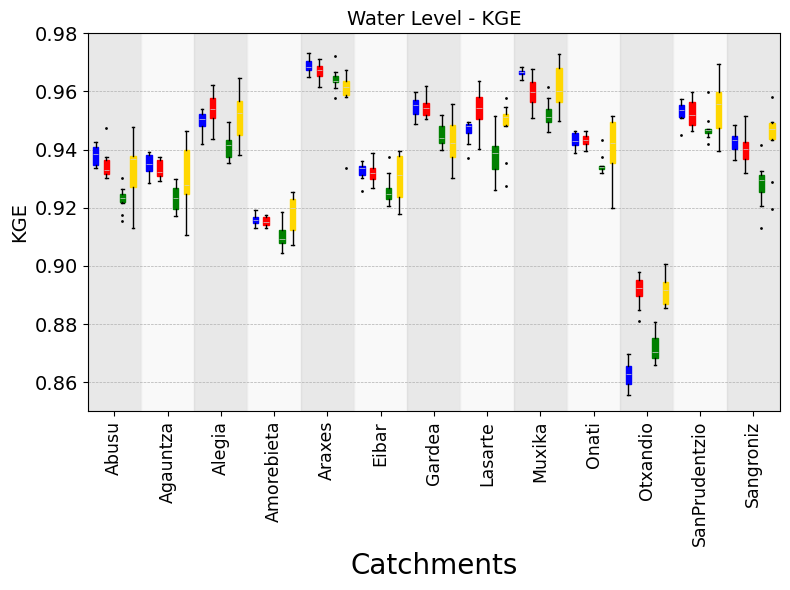

In [142]:
# 07 _ 01 - This code plots Box-plots for all seeds of all models in prallel for each of the Filtered_basins for showing on Paper (Figure 04)

# Define the basins for plotting
Basins_left_plot_qmean  = ['Abetxuko', 'Aitzu', 'Alegria', 'Anarbe', 'Areta', 'Balmaseda', 'Elorrio', 'Erenozu', 'Estanda', 'Etura', 'Ibaieder', 'Jaizubia', 'Larrainazubi', 'Leitzaran', 'Markina', 'Muxika', 'Ozaeta', 'Saratxo', 'Sodupe', 'Urkizu']
Basins_left_plot_lmean  = ['Areta', 'Balmaseda', 'Elorrio', 'Estanda', 'Etura', 'Gatika', 'Herrerias', 'Jaizubia', 'Larrainazubi', 'Markina', 'Ozaeta', 'Saratxo', 'Urkizu', 'Zaratamo']
Basins_right_plot_qmean = [basin for basin in URA_basins if basin not in Basins_left_plot_qmean]
Basins_right_plot_lmean = [basin for basin in URAlevel_basins if basin not in Basins_left_plot_lmean]
hatch_patterns = ['+', 'x', 'o', '*']

# Configuration mapping for plotting parameters
plot_configs = {
    1: {'variable': 'qmean', 'metric': 'NSE', 'basins': Basins_left_plot_qmean, 'a': 0.7, 'b': 0.93, 'c': 19.5},
    2: {'variable': 'qmean', 'metric': 'NSE', 'basins': Basins_right_plot_qmean, 'a': 0.89, 'b': 0.98, 'c': 19.5},
    3: {'variable': 'qmean', 'metric': 'KGE', 'basins': Basins_left_plot_qmean, 'a': 0.55, 'b': 0.97, 'c': 19.5},
    4: {'variable': 'qmean', 'metric': 'KGE', 'basins': Basins_right_plot_qmean, 'a': 0.82, 'b': 0.99, 'c': 19.5},
    5: {'variable': 'lmean', 'metric': 'NSE', 'basins': Basins_left_plot_lmean, 'a': 0.8, 'b': 0.95, 'c': 13.5},
    6: {'variable': 'lmean', 'metric': 'NSE', 'basins': Basins_right_plot_lmean, 'a': 0.91, 'b': 0.98, 'c': 12.5},
    7: {'variable': 'lmean', 'metric': 'KGE', 'basins': Basins_left_plot_lmean, 'a': 0.82, 'b': 0.96, 'c': 13.5},
    8: {'variable': 'lmean', 'metric': 'KGE', 'basins': Basins_right_plot_lmean, 'a': 0.85, 'b': 0.98, 'c': 12.5}
}

# Function to extract data for plotting
def extract_data(basins, variable, metric, data_dict):
    data = {basin: [] for basin in basins}
    for seed in data_dict.keys():
        for basin in basins:
            data[basin].append(data_dict[seed]["1H"][basin][variable][metric])
    return [data[basin] for basin in basins]

# Function to create box plots for each basin
def create_boxplots(ax, data, positions, color, label, hatch_pattern):
    ax.boxplot(
        data,
        positions=[positions],
        widths=0.1,
        patch_artist=True,
        boxprops=dict(facecolor=color, edgecolor=color, hatch=hatch_pattern),
        showmeans=False,
        labels=[label],
        flierprops=dict(marker='o', markersize=1, markerfacecolor='lightgray'),
        medianprops=dict(color='lightgray', linestyle='-', linewidth=0.5)
    )

# Iterate over the configurations
for num in plot_configs:
    config = plot_configs[num]
    variable, metric, basins, a, b, c = config.values()

    # Extract data for plotting
    boxplot_data_Catchment_Wise_Configs = extract_data(basins, variable, metric, Catchment_Wise_Configs_metrics)
    boxplot_data_Top_10 = extract_data(basins, variable, metric, Top_10_Configs_metrics)
    boxplot_data_K_means = extract_data(basins, variable, metric, K_means_Configs_metrics)
    boxplot_data_ERO = extract_data(basins, variable, metric, Enhanced_Regional_Optimal_ERO_metrics)

    # Initialize figure and axis objects
    if num == 3 or 4 or 7 or 8:
        fig, ax = plt.subplots(figsize=(8, 6))
    else:
        fig, ax = plt.subplots(figsize=(8, 5))

    # Set positions for the box plots
    positions = np.arange(len(basins))

    # Set minor ticks between major ticks to customize gridlines
    minor_ticks = np.arange(-0.5, len(basins) - 0.5, 1)

    # Show minor gridlines
    ax.grid(which='minor', linestyle='--', linewidth='0.75', color='dimgray')

    # Set Y-axis limits
    ax.set_xlim(-0.5, c)
    ax.set_ylim(a, b)

    # Shade the background between gridlines with alternating shades of gray
    for i in range(len(basins)):
        color = 'lightgrey' if i % 2 == 0 else 'whitesmoke'
        ax.fill_betweenx(ax.get_ylim(), i - 0.5, i + 0.5, color=color, alpha=0.5)

    # Iterate over each basin and plot the box plots side by side
    for i, basin in enumerate(basins):
        # Calculate positions for parallel plots
        position01 = i - 0.35
        position02 = i - 0.15
        position03 = i + 0.15
        position04 = i + 0.35

        # Plot box plots
        create_boxplots(ax, boxplot_data_Catchment_Wise_Configs[i], position01, 'blue', f'{basin}', hatch_patterns[0])
        create_boxplots(ax, boxplot_data_Top_10[i], position02, 'red', f'{basin}', hatch_patterns[1])
        create_boxplots(ax, boxplot_data_K_means[i], position03, 'green', f'{basin}', hatch_patterns[2])
        create_boxplots(ax, boxplot_data_ERO[i], position04, 'gold', f'{basin}', hatch_patterns[3])

    # Set x-axis labels based on num value
    if num in [3, 4, 7, 8]:  # Show x-axis labels for these nums
        ax.set_xticks(np.arange(len(basins)))
        fontsize = 14 if num in [3, 7] else 12.5  # Conditional fontsize
        ax.set_xticklabels(basins, rotation=90, fontsize=fontsize)
    else:
        # Remove x-axis labels and ticks
        ax.set_xticks([])
        ax.set_xticklabels([])

    # Set title and labels
    title_variable = "Streamflow" if variable == 'qmean' else "Water Level"
    ax.set_title(f'{title_variable} - {metric}', fontsize=14)
    ax.set_ylabel(f'{metric}', fontsize=14)
    ax.tick_params(axis='y', which='major', labelsize=14)

    # Create custom legend patches
    legend_patches = [
        mpatches.Patch(color='blue', label='Catchment-Wise'),
        mpatches.Patch(color='red', label='Top 10'),
        mpatches.Patch(color='green', label='K-means'),
        mpatches.Patch(color='gold', label='ERO')
    ]

    # Set y-axis major gridlines every 0.1 units
    ax.yaxis.grid(True, which='major', linestyle='--', linewidth=0.5)

    # Add legend to the plot
    if num == 1:
        plt.legend(handles=legend_patches, loc='lower left', bbox_to_anchor=(0.05, 0.02), fontsize=12)
    plt.yticks(fontsize=14)
    if num in [3, 4, 7, 8]:
        ax.set_xlabel('Catchments', fontsize=20)

    # Adjust layout
    plt.tight_layout()

    # Define the directory to save the plots
    save_dir = r"...\Supplementary_materials\Figures\BoxPlots"

    # Save the plot to a file
    save_path = os.path.join(save_dir, f'{num}_{metric}_{variable}.tiff')
    os.makedirs(os.path.dirname(save_path), exist_ok=True)  # Create folder if it doesn't exist
    plt.savefig(save_path, dpi=300)




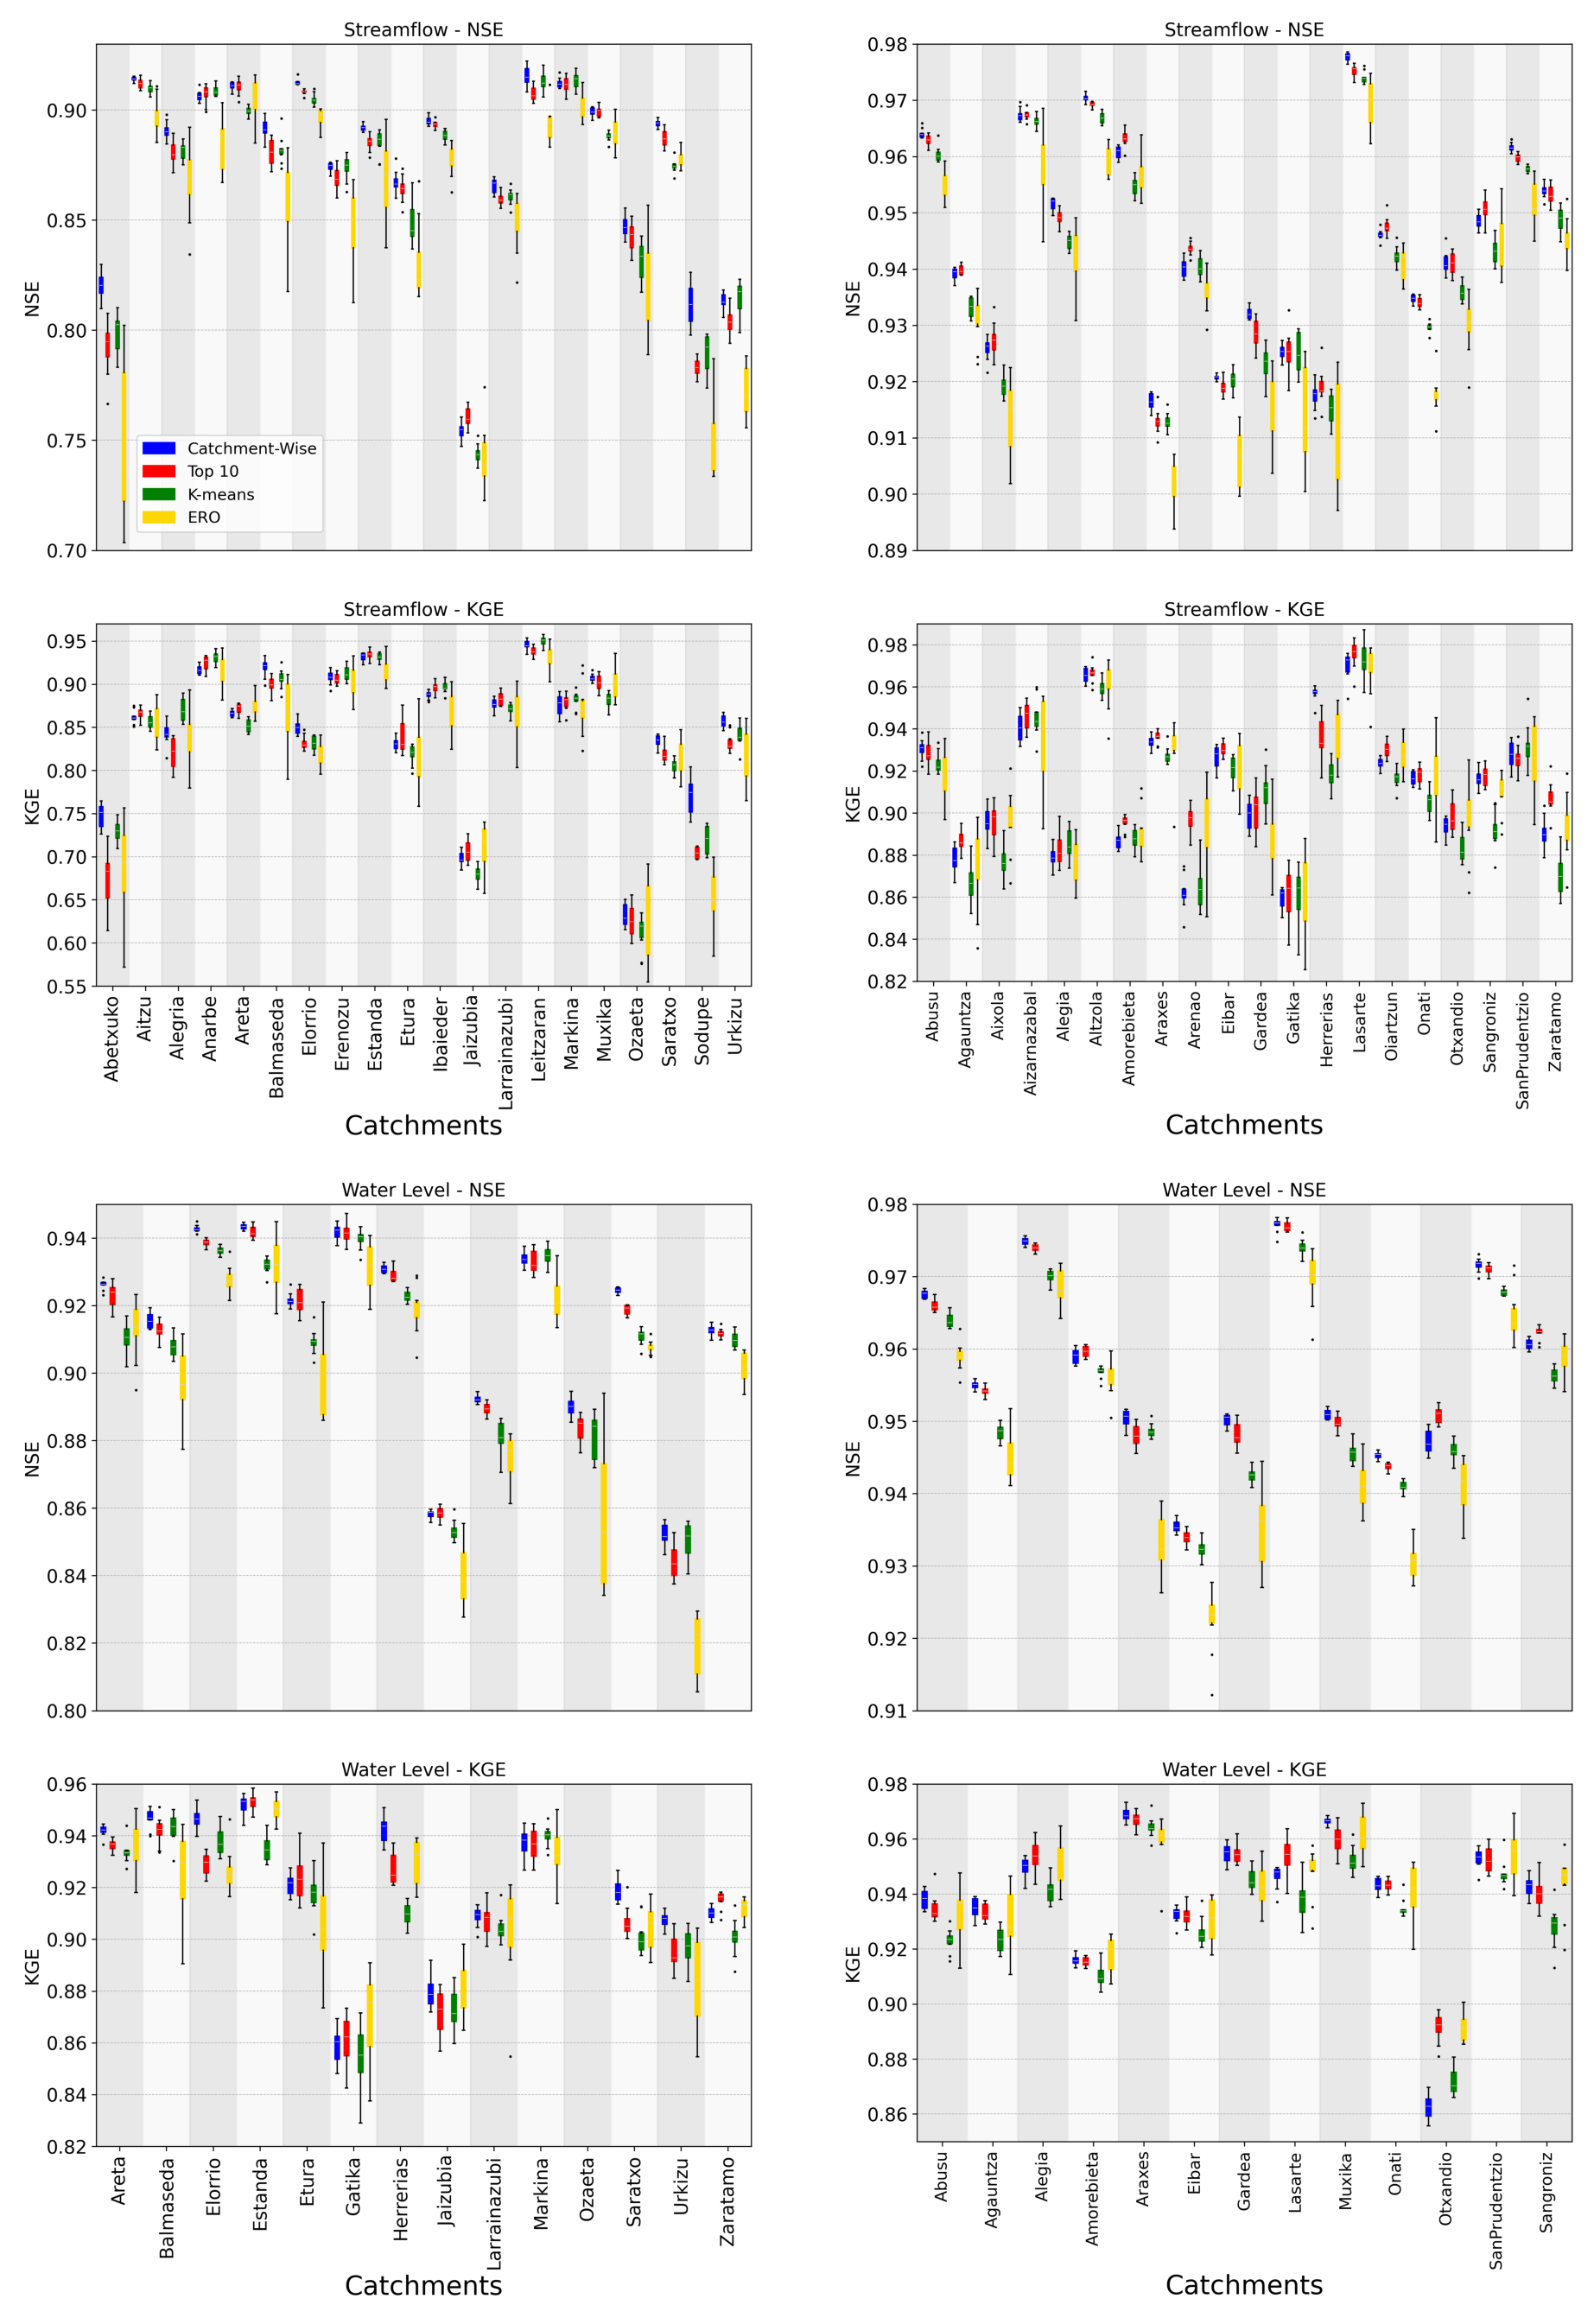

In [144]:
# 07_ 02 (final Figure 04)

# Define the paths to the figures
fig_paths = [
    r"...\Supplementary_materials\Figures\BoxPlots\1_NSE_qmean.tiff",
    r"...\Supplementary_materials\Figures\BoxPlots\2_NSE_qmean.tiff",
    r"...\Supplementary_materials\Figures\BoxPlots\3_KGE_qmean.tiff",
    r"...\Supplementary_materials\Figures\BoxPlots\4_KGE_qmean.tiff",
    r"...\Supplementary_materials\Figures\BoxPlots\5_NSE_lmean.tiff",
    r"...\Supplementary_materials\Figures\BoxPlots\6_NSE_lmean.tiff",
    r"...\Supplementary_materials\Figures\BoxPlots\7_KGE_lmean.tiff",
    r"...\Supplementary_materials\Figures\BoxPlots\8_KGE_lmean.tiff",
]

# Create a 4x2 grid of subplots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20, 27))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through each subplot and add the corresponding figure
for i, ax in enumerate(axes):
    img = imread(fig_paths[i])
    ax.imshow(img)
    ax.axis('off')  # Hide axis labels

# Adjust the layout to decrease space between figures
plt.subplots_adjust(wspace=0.02, hspace=0.02)  # You can adjust these values as needed

# Adjust layout to prevent overlap
plt.tight_layout()

# Define the directory to save the plots
save_dir = r"...\Supplementary_materials\Figures"

# Save the plot to a PDF file
save_path = os.path.join(save_dir, 'Figure04.pdf')
os.makedirs(os.path.dirname(save_path), exist_ok=True)  # Create folder if it doesn't exist
plt.savefig(save_path, format='pdf', dpi=600)

# Save the plot to a TIFF file
save_path = os.path.join(save_dir, 'Figure04.tiff')
os.makedirs(os.path.dirname(save_path), exist_ok=True)  # Create folder if it doesn't exist
plt.savefig(save_path, format='tiff', dpi=600)

# Save the plot to a PNG file
save_path = os.path.join(save_dir, 'Figure04.png')
os.makedirs(os.path.dirname(save_path), exist_ok=True)  # Create folder if it doesn't exist
plt.savefig(save_path, format='tiff', dpi=300)

# Show the combined figure
plt.show()


In [145]:
# 08_01 - The following will be used to plot next figures

variables = ['qmean', 'lmean']
metrics = ['NSE', 'KGE']      

data_Catchment_Wise_Configs = {}
data_Top_10 = {}
data_K_means = {}
data_ERO = {}

for variable in variables:
    for metric in metrics:
        if variable == 'lmean':
            Basins = URAlevel_basins
        else:
            Basins = URA_basins

        if variable not in data_Catchment_Wise_Configs:
            data_Catchment_Wise_Configs[variable] = {}
        if variable not in data_Top_10:
            data_Top_10[variable] = {}
        if variable not in data_K_means:
            data_K_means[variable] = {}
        if variable not in data_ERO:
            data_ERO[variable] = {}

        data_Catchment_Wise_Configs[variable][metric] = {Basin: [] for Basin in Basins}
        data_Top_10[variable][metric] = {Basin: [] for Basin in Basins}
        data_K_means[variable][metric] = {Basin: [] for Basin in Basins}
        data_ERO[variable][metric] = {Basin: [] for Basin in Basins}

        for seed in seeds:
            for Basin in Basins:
                data_Catchment_Wise_Configs[variable][metric][Basin].append(Catchment_Wise_Configs_metrics[seed]["1H"][Basin][variable][metric])

        for seed in seeds:
            for Basin in Basins:
                data_Top_10[variable][metric][Basin].append(Top_10_Configs_metrics[seed]["1H"][Basin][variable][metric])

        for seed in seeds:
            for Basin in Basins:
                data_K_means[variable][metric][Basin].append(K_means_Configs_metrics[seed]["1H"][Basin][variable][metric])
        for seed in seeds:
            for Basin in Basins:
                data_ERO[variable][metric][Basin].append(Enhanced_Regional_Optimal_ERO_metrics[seed]["1H"][Basin][variable][metric])

cdfplot_data_Catchment_Wise_Configs = {}
cdfplot_data_Top_10 = {}
cdfplot_data_K_means = {}
cdfplot_data_ERO = {}

for variable in variables:
    for metric in metrics:
        if variable not in cdfplot_data_Catchment_Wise_Configs:
            cdfplot_data_Catchment_Wise_Configs[variable] = {}
        if variable not in cdfplot_data_Top_10:
            cdfplot_data_Top_10[variable] = {}
        if variable not in cdfplot_data_K_means:
            cdfplot_data_K_means[variable] = {}
        if variable not in cdfplot_data_ERO:
            cdfplot_data_ERO[variable] = {}

        # Initialize a dictionary to store the data for each basin
        cdfplot_data_Catchment_Wise_Configs[variable][metric] = {i: [] for i in range(10)}
        cdfplot_data_Top_10[variable][metric] = {i: [] for i in range(10)}
        cdfplot_data_K_means[variable][metric] = {i: [] for i in range(10)}
        cdfplot_data_ERO[variable][metric] = {i: [] for i in range(10)}

        # Populate the cdfplot_data dictionaries with the data for each basin
        for i in range(10):
            for Basin in Basins:
                cdfplot_data_Catchment_Wise_Configs[variable][metric][i].append(data_Catchment_Wise_Configs[variable][metric][Basin][i])
                cdfplot_data_Top_10[variable][metric][i].append(data_Top_10[variable][metric][Basin][i])
                cdfplot_data_K_means[variable][metric][i].append(data_K_means[variable][metric][Basin][i])
                cdfplot_data_ERO[variable][metric][i].append(data_ERO[variable][metric][Basin][i])


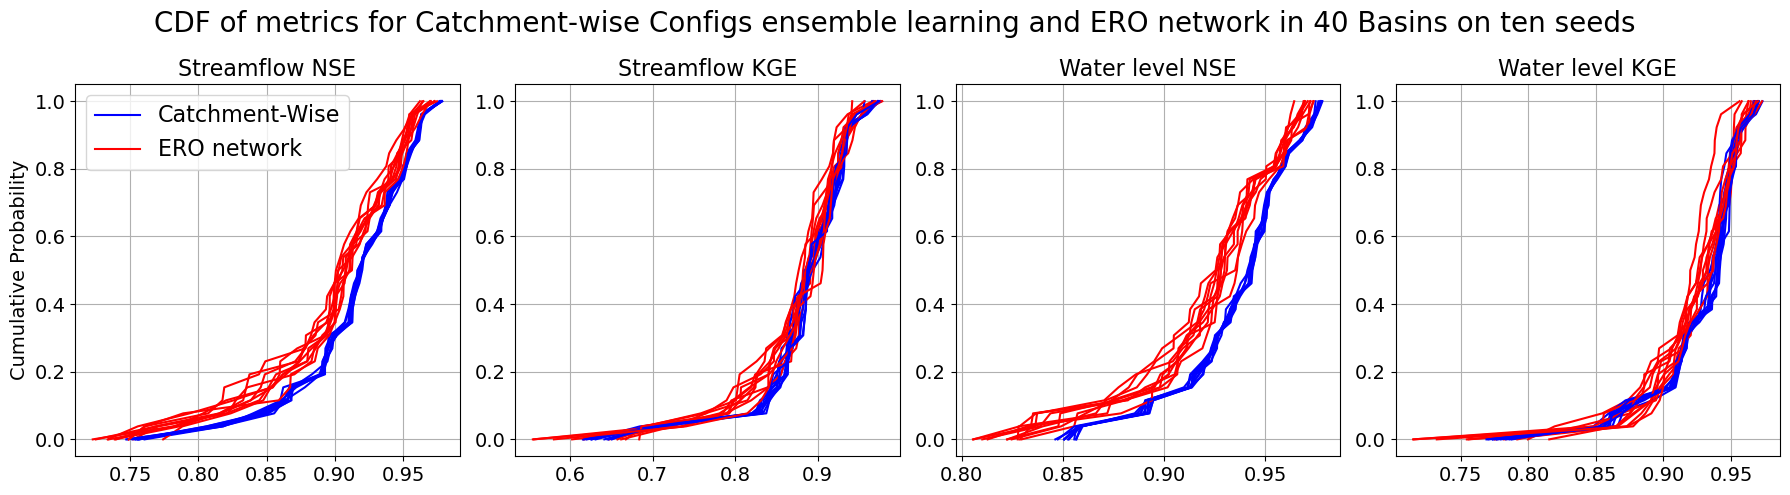

In [147]:
# 08_02 - Function to plot CDF for each variable with specified colors (Figure 06)
def plot_cdfs(data1, data2, title, ax, color1, color2, legend, ylable):
    for i in range(10):
        sorted_data1 = np.sort(data1[i])
        yvals1 = np.arange(len(sorted_data1)) / float(len(sorted_data1) - 1)
        sorted_data2 = np.sort(data2[i])
        yvals2 = np.arange(len(sorted_data2)) / float(len(sorted_data2) - 1)
        if i == 0:
            ax.plot(sorted_data1, yvals1, linestyle='-', color=color1, label=f'Catchment-Wise')
            ax.plot(sorted_data2, yvals2, linestyle='-', color=color2, label=f'ERO network')
        else:
            ax.plot(sorted_data1, yvals1, linestyle='-', color=color1)
            ax.plot(sorted_data2, yvals2, linestyle='-', color=color2)
    if ylable ==1:
        ax.set_ylabel('Cumulative Probability', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.grid(True)
    ax.tick_params(axis='both', which='major', labelsize=14)
    if legend == 1:
        ax.legend(fontsize=16)

# Define the number of rows and columns for the subplots
num_rows = 1
num_cols = 4

# Create subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(18, 5))

# Plot CDF for ERO in blue and RO in red
plot_cdfs(cdfplot_data_Catchment_Wise_Configs['qmean']['NSE'], cdfplot_data_ERO['qmean']['NSE'], 'Streamflow NSE', axs[0], 'blue', 'red', 1, 1)
plot_cdfs(cdfplot_data_Catchment_Wise_Configs['qmean']['KGE'], cdfplot_data_ERO['qmean']['KGE'], 'Streamflow KGE', axs[1], 'blue', 'red', 0, 0)
plot_cdfs(cdfplot_data_Catchment_Wise_Configs['lmean']['NSE'], cdfplot_data_ERO['lmean']['NSE'], 'Water level NSE', axs[2], 'blue', 'red', 0, 0)
plot_cdfs(cdfplot_data_Catchment_Wise_Configs['lmean']['KGE'], cdfplot_data_ERO['lmean']['KGE'], 'Water level KGE', axs[3], 'blue', 'red', 0, 0)

# Add title to the main figure
fig.suptitle('CDF of metrics for Catchment-wise Configs ensemble learning and ERO network in 40 Basins on ten seeds', fontsize=20)

# Adjust layout
plt.tight_layout()

# Define the directory to save the plots
save_dir = r"...\Supplementary_materials\Figures\CDFs"

# Save the plot to a file
save_path = os.path.join(save_dir, 'CDF_Catchmen_wise.vs.ERO.png')
os.makedirs(os.path.dirname(save_path), exist_ok=True)  # Create folder if it doesn't exist
plt.savefig(save_path, dpi=300)

plt.show()


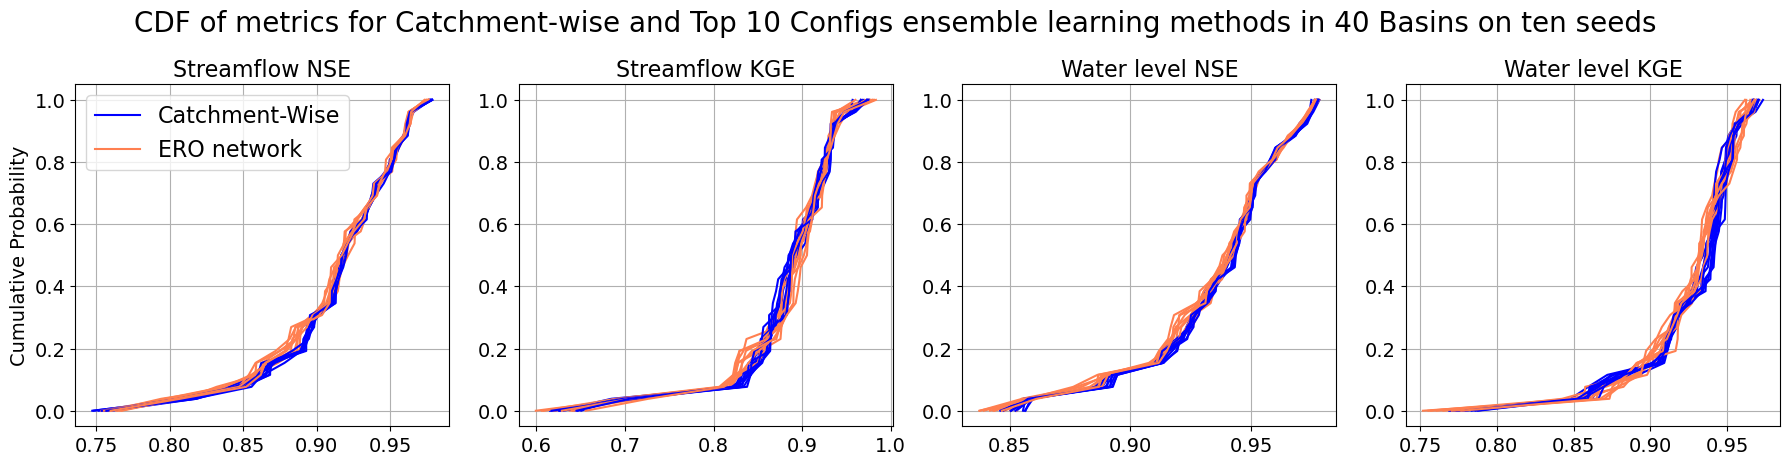

In [148]:

# 08_02 - Create subplots (Figure 06)
fig, axs = plt.subplots(num_rows, num_cols, figsize=(18, 4.7))

# Plot CDF for ERO in blue and RO in red
plot_cdfs(cdfplot_data_Catchment_Wise_Configs['qmean']['NSE'], cdfplot_data_Top_10['qmean']['NSE'], 'Streamflow NSE', axs[0], 'blue', 'Coral', 1, 1)
plot_cdfs(cdfplot_data_Catchment_Wise_Configs['qmean']['KGE'], cdfplot_data_Top_10['qmean']['KGE'], 'Streamflow KGE', axs[1], 'blue', 'Coral', 0, 0)
plot_cdfs(cdfplot_data_Catchment_Wise_Configs['lmean']['NSE'], cdfplot_data_Top_10['lmean']['NSE'], 'Water level NSE', axs[2], 'blue', 'Coral', 0, 0)
plot_cdfs(cdfplot_data_Catchment_Wise_Configs['lmean']['KGE'], cdfplot_data_Top_10['lmean']['KGE'], 'Water level KGE', axs[3], 'blue', 'Coral', 0, 0)

# Add title to the main figure
fig.suptitle('CDF of metrics for Catchment-wise and Top 10 Configs ensemble learning methods in 40 Basins on ten seeds', fontsize=20)

# Adjust layout
plt.tight_layout()

# Define the directory to save the plots
save_dir = r"...\Supplementary_materials\Figures\CDFs"

# Save the plot to a file
save_path = os.path.join(save_dir, 'CDF_Catchmen_wise.vs.Top10.png')
os.makedirs(os.path.dirname(save_path), exist_ok=True)  # Create folder if it doesn't exist
plt.savefig(save_path, dpi=300)

plt.show()


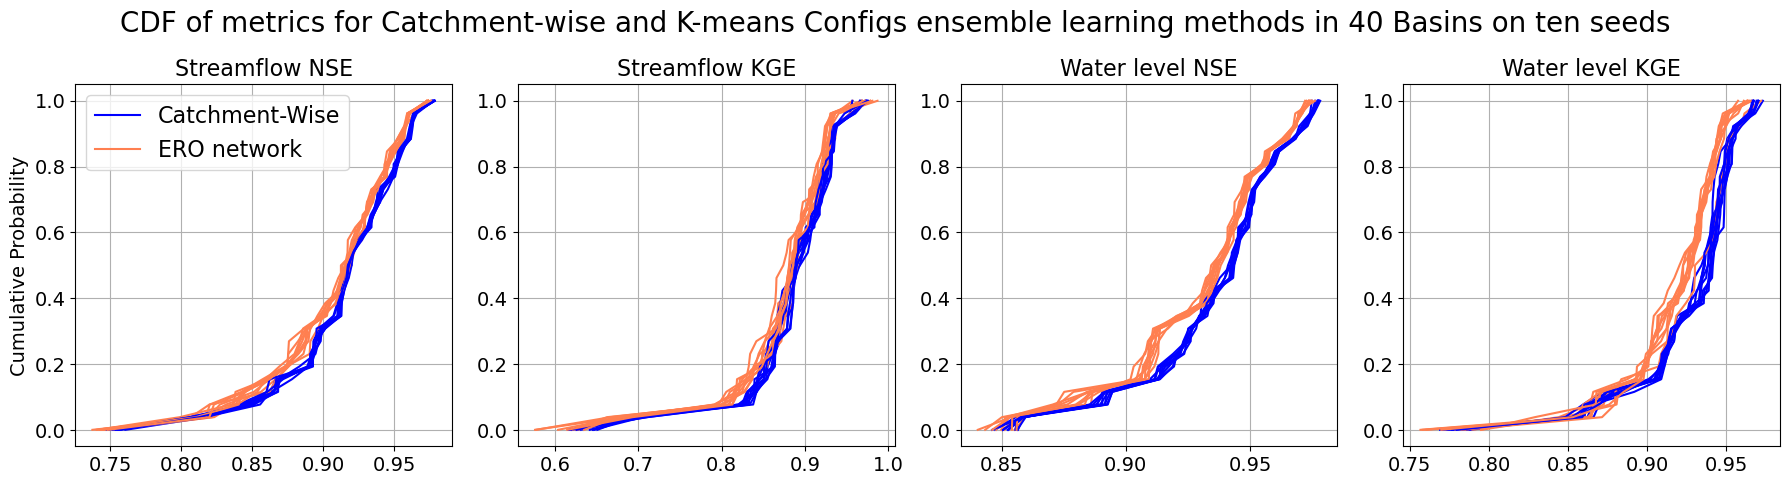

In [149]:

# 08_02 - Create subplots (Figure 06)
fig, axs = plt.subplots(num_rows, num_cols, figsize=(18, 4.9))

# Plot CDF for ERO in blue and RO in red
plot_cdfs(cdfplot_data_Catchment_Wise_Configs['qmean']['NSE'], cdfplot_data_K_means['qmean']['NSE'], 'Streamflow NSE', axs[0], 'blue', 'Coral', 1, 1)
plot_cdfs(cdfplot_data_Catchment_Wise_Configs['qmean']['KGE'], cdfplot_data_K_means['qmean']['KGE'], 'Streamflow KGE', axs[1], 'blue', 'Coral', 0, 0)
plot_cdfs(cdfplot_data_Catchment_Wise_Configs['lmean']['NSE'], cdfplot_data_K_means['lmean']['NSE'], 'Water level NSE', axs[2], 'blue', 'Coral', 0, 0)
plot_cdfs(cdfplot_data_Catchment_Wise_Configs['lmean']['KGE'], cdfplot_data_K_means['lmean']['KGE'], 'Water level KGE', axs[3], 'blue', 'Coral', 0, 0)

# Add title to the main figure
fig.suptitle('CDF of metrics for Catchment-wise and K-means Configs ensemble learning methods in 40 Basins on ten seeds', fontsize=20)

# Adjust layout
plt.tight_layout()

# Define the directory to save the plots
save_dir = r"...\Supplementary_materials\Figures\CDFs"

# Save the plot to a file
save_path = os.path.join(save_dir, 'CDF_Catchmen_wise.vs.K_means.png')
os.makedirs(os.path.dirname(save_path), exist_ok=True)  # Create folder if it doesn't exist
plt.savefig(save_path, dpi=300)

plt.show()


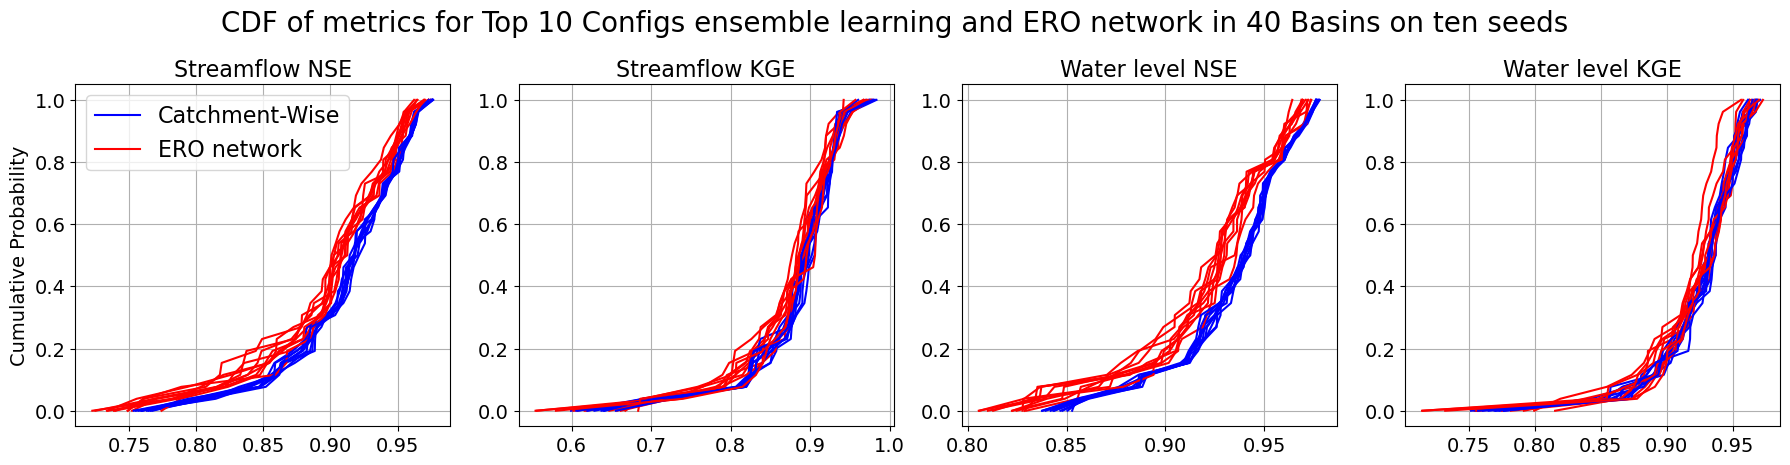

In [150]:

# 08_02 - Create subplots (Figure 06)
fig, axs = plt.subplots(num_rows, num_cols, figsize=(18, 4.7))

# Plot CDF for ERO in blue and RO in red
plot_cdfs(cdfplot_data_Top_10['qmean']['NSE'], cdfplot_data_ERO['qmean']['NSE'], 'Streamflow NSE', axs[0], 'blue', 'red', 1, 1)
plot_cdfs(cdfplot_data_Top_10['qmean']['KGE'], cdfplot_data_ERO['qmean']['KGE'], 'Streamflow KGE', axs[1], 'blue', 'red', 0, 0)
plot_cdfs(cdfplot_data_Top_10['lmean']['NSE'], cdfplot_data_ERO['lmean']['NSE'], 'Water level NSE', axs[2], 'blue', 'red', 0, 0)
plot_cdfs(cdfplot_data_Top_10['lmean']['KGE'], cdfplot_data_ERO['lmean']['KGE'], 'Water level KGE', axs[3], 'blue', 'red', 0, 0)

# Add title to the main figure
fig.suptitle('CDF of metrics for Top 10 Configs ensemble learning and ERO network in 40 Basins on ten seeds', fontsize=20)

# Adjust layout
plt.tight_layout()

# Define the directory to save the plots
save_dir = r"...\Supplementary_materials\Figures\CDFs"

# Save the plot to a file
save_path = os.path.join(save_dir, 'CDF_Top10.vs.ERO.png')
os.makedirs(os.path.dirname(save_path), exist_ok=True)  # Create folder if it doesn't exist
plt.savefig(save_path, dpi=300)

plt.show()


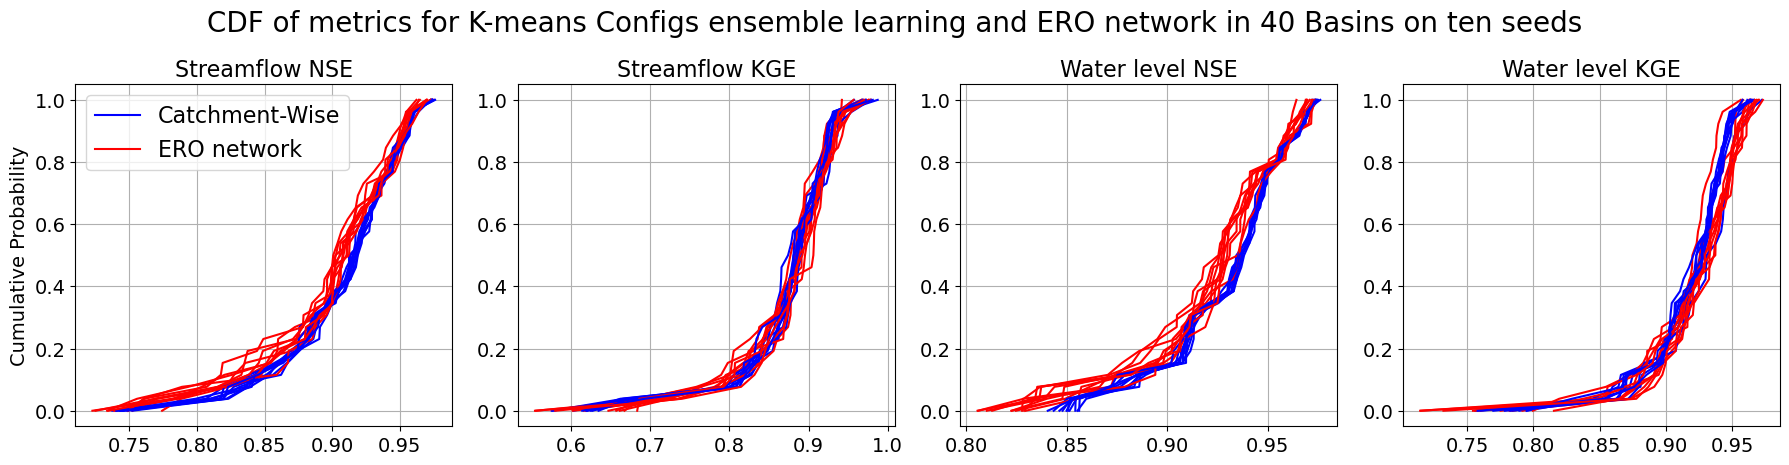

In [151]:

# 08_02 - Create subplots (Figure 06)
fig, axs = plt.subplots(num_rows, num_cols, figsize=(18, 4.7))

# Plot CDF for ERO in blue and RO in red
plot_cdfs(cdfplot_data_K_means['qmean']['NSE'], cdfplot_data_ERO['qmean']['NSE'], 'Streamflow NSE', axs[0], 'blue', 'red', 1, 1)
plot_cdfs(cdfplot_data_K_means['qmean']['KGE'], cdfplot_data_ERO['qmean']['KGE'], 'Streamflow KGE', axs[1], 'blue', 'red', 0, 0)
plot_cdfs(cdfplot_data_K_means['lmean']['NSE'], cdfplot_data_ERO['lmean']['NSE'], 'Water level NSE', axs[2], 'blue', 'red', 0, 0)
plot_cdfs(cdfplot_data_K_means['lmean']['KGE'], cdfplot_data_ERO['lmean']['KGE'], 'Water level KGE', axs[3], 'blue', 'red', 0, 0)

# Add title to the main figure
fig.suptitle('CDF of metrics for K-means Configs ensemble learning and ERO network in 40 Basins on ten seeds', fontsize=20)

# Adjust layout
plt.tight_layout()

# Define the directory to save the plots
save_dir = r"...\Supplementary_materials\Figures\CDFs"

# Save the plot to a file
save_path = os.path.join(save_dir, 'CDF_K_means.vs.ERO.png')
os.makedirs(os.path.dirname(save_path), exist_ok=True)  # Create folder if it doesn't exist
plt.savefig(save_path, dpi=300)

plt.show()


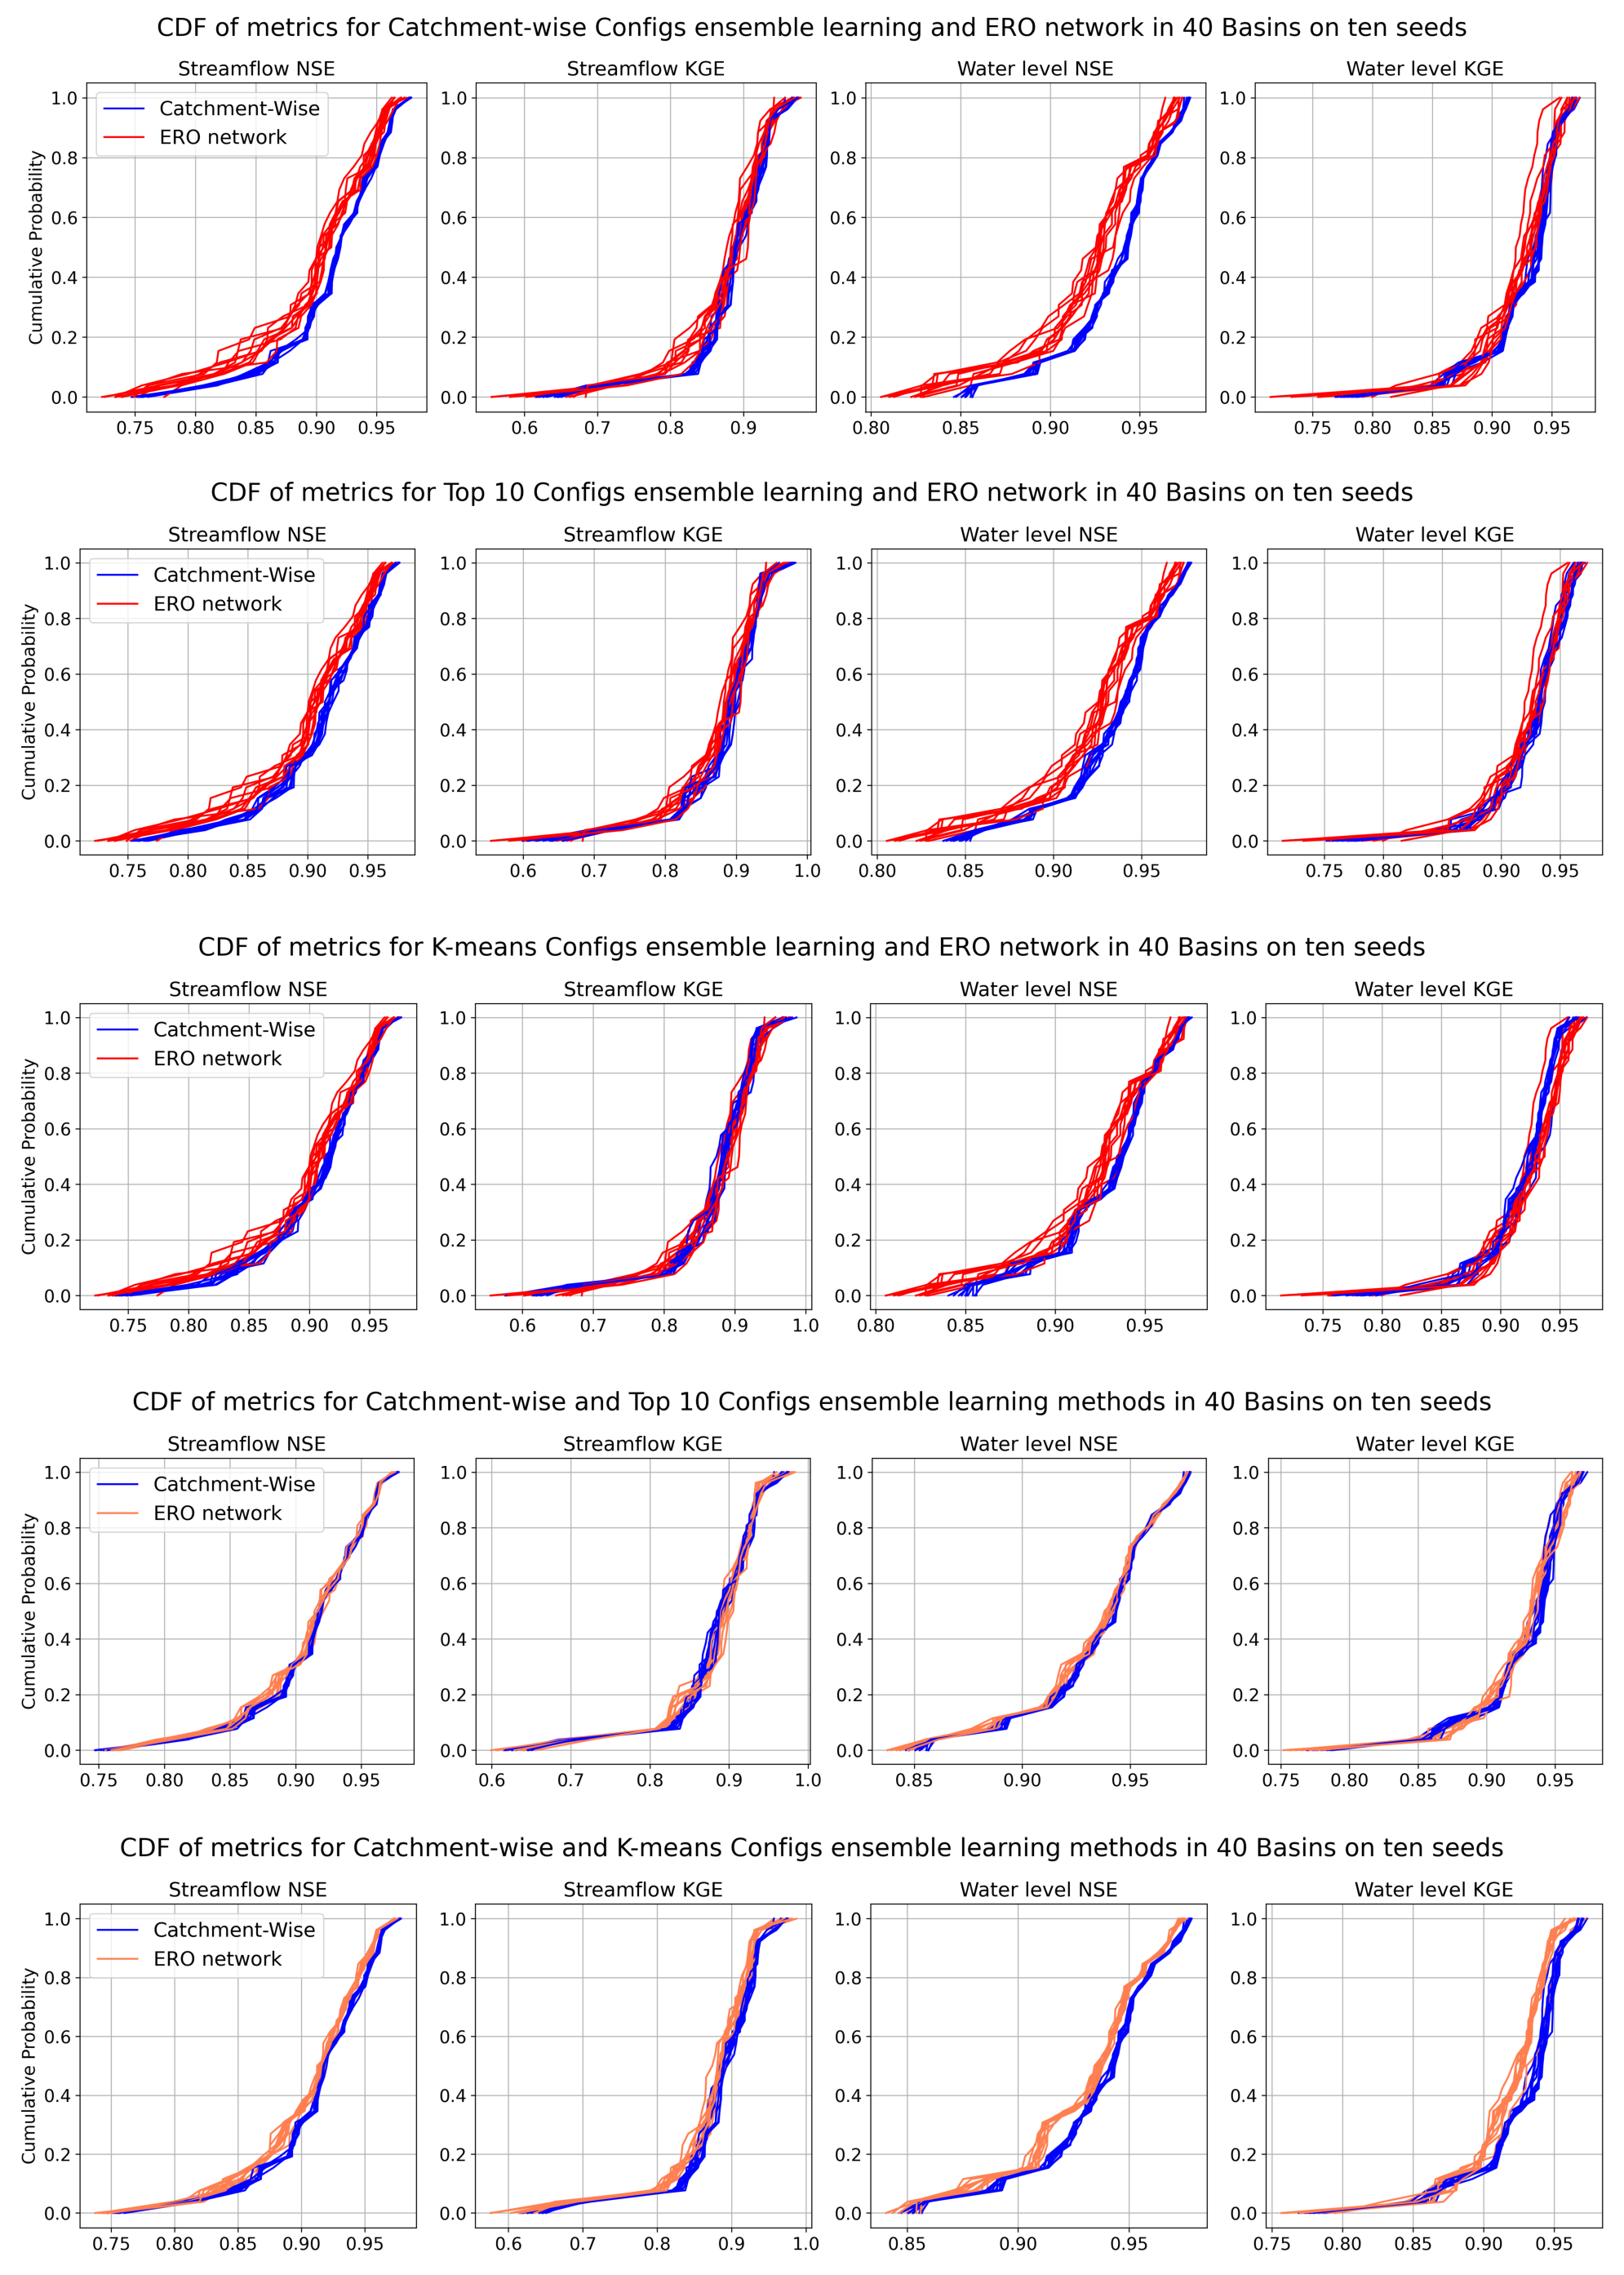

In [152]:
## 08_03 - This code combines all 4 figures for the paper (final Figure 06)

# Load your figures
fig_paths = [
    r"...\Supplementary_materials\Figures\CDFs\CDF_Catchmen_wise.vs.ERO.png",
    r"...\Supplementary_materials\Figures\CDFs\CDF_Top10.vs.ERO.png",
    r"...\Supplementary_materials\Figures\CDFs\CDF_K_means.vs.ERO.png",
    r"...\Supplementary_materials\Figures\CDFs\CDF_Catchmen_wise.vs.Top10.png",
    r"...\Supplementary_materials\Figures\CDFs\CDF_Catchmen_wise.vs.K_means.png"
]

# Create a 5x1 grid of subplots
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(20, 28))

# Loop through each subplot and add the corresponding figure
for i, ax in enumerate(axes):
    img = imread(fig_paths[i])
    ax.imshow(img)
    ax.axis('off')  # Hide axis labels

# Adjust layout to prevent overlap
plt.tight_layout()

# Define the directory to save the plots
save_dir = r"...\Supplementary_materials\Figures"

# Save the plot to a file
save_path = os.path.join(save_dir, f'Figure06.pdf')
os.makedirs(os.path.dirname(save_path), exist_ok=True)  # Create folder if it doesn't exist
plt.savefig(save_path, format='pdf', dpi=600)

# Save the plot to a TIFF file
save_path = os.path.join(save_dir, 'Figure06.tiff')
os.makedirs(os.path.dirname(save_path), exist_ok=True)  # Create folder if it doesn't exist
plt.savefig(save_path, format='tiff', dpi=600)

# Save the plot to a PNG file
save_path = os.path.join(save_dir, 'Figure06.png')
os.makedirs(os.path.dirname(save_path), exist_ok=True)  # Create folder if it doesn't exist
plt.savefig(save_path, format='tiff', dpi=300)

plt.show()  # Display the combined figure


## Performing Statistical Analyses

In [153]:
# 09_01 - This code will be used for plotting the outcomes of statistical tests
# Load the Excel file into a DataFrame

file_path_Catchment_Wise = r'...\Supplementary_materials\Results\Catchment_Wise_Configs_metrics.xlsx'
file_path_Top_10 = r'...\Supplementary_materials\Results\Top_10_Configs_metrics.xlsx'
file_path_K_means = r'...\Supplementary_materials\Results\K_means_Configs_metrics.xlsx'
file_path_ERO = r'...\Supplementary_materials\Results\ERO_metrics.xlsx'
df_Catchment_Wise = pd.read_excel(file_path_Catchment_Wise)
df_Top_10 = pd.read_excel(file_path_Top_10)
df_K_means = pd.read_excel(file_path_K_means)
df_ERO = pd.read_excel(file_path_ERO)

# Extract relevant columns
df_regional_Catchment_Wise_NSE_SF   = df_Catchment_Wise[['basin', 'seed', 'SFmean_NSE']]
df_regional_Catchment_Wise_KGE_SF   = df_Catchment_Wise[['basin', 'seed', 'SFmean_KGE']]
df_regional_Catchment_Wise_NSE_WL   = df_Catchment_Wise[['basin', 'seed', 'WLmean_NSE']]
df_regional_Catchment_Wise_KGE_WL   = df_Catchment_Wise[['basin', 'seed', 'WLmean_KGE']]
df_regional_Top_10_NSE_SF   = df_Top_10[['basin', 'seed', 'SFmean_NSE']]
df_regional_Top_10_KGE_SF   = df_Top_10[['basin', 'seed', 'SFmean_KGE']]
df_regional_Top_10_NSE_WL   = df_Top_10[['basin', 'seed', 'WLmean_NSE']]
df_regional_Top_10_KGE_WL   = df_Top_10[['basin', 'seed', 'WLmean_KGE']]
df_regional_K_means_NSE_SF   = df_K_means[['basin', 'seed', 'SFmean_NSE']]
df_regional_K_means_KGE_SF   = df_K_means[['basin', 'seed', 'SFmean_KGE']]
df_regional_K_means_NSE_WL   = df_K_means[['basin', 'seed', 'WLmean_NSE']]
df_regional_K_means_KGE_WL   = df_K_means[['basin', 'seed', 'WLmean_KGE']]
df_regional_ERO_NSE_SF   = df_ERO[['basin', 'seed', 'SFmean_NSE']]
df_regional_ERO_KGE_SF   = df_ERO[['basin', 'seed', 'SFmean_KGE']]
df_regional_ERO_NSE_WL   = df_ERO[['basin', 'seed', 'WLmean_NSE']]
df_regional_ERO_KGE_WL   = df_ERO[['basin', 'seed', 'WLmean_KGE']]

# Pivot the DataFrame to get the desired structure
df_regional_Catchment_Wise_NSE_SF   = df_regional_Catchment_Wise_NSE_SF.pivot_table(index='basin', columns='seed', values='SFmean_NSE', aggfunc='mean')
df_regional_Catchment_Wise_KGE_SF   = df_regional_Catchment_Wise_KGE_SF.pivot_table(index='basin', columns='seed', values='SFmean_KGE', aggfunc='mean')
df_regional_Catchment_Wise_NSE_WL   = df_regional_Catchment_Wise_NSE_WL.pivot_table(index='basin', columns='seed', values='WLmean_NSE', aggfunc='mean')
df_regional_Catchment_Wise_KGE_WL   = df_regional_Catchment_Wise_KGE_WL.pivot_table(index='basin', columns='seed', values='WLmean_KGE', aggfunc='mean')
df_regional_Top_10_NSE_SF   = df_regional_Top_10_NSE_SF.pivot_table(index='basin', columns='seed', values='SFmean_NSE', aggfunc='mean')
df_regional_Top_10_KGE_SF   = df_regional_Top_10_KGE_SF.pivot_table(index='basin', columns='seed', values='SFmean_KGE', aggfunc='mean')
df_regional_Top_10_NSE_WL   = df_regional_Top_10_NSE_WL.pivot_table(index='basin', columns='seed', values='WLmean_NSE', aggfunc='mean')
df_regional_Top_10_KGE_WL   = df_regional_Top_10_KGE_WL.pivot_table(index='basin', columns='seed', values='WLmean_KGE', aggfunc='mean')
df_regional_K_means_NSE_SF   = df_regional_K_means_NSE_SF.pivot_table(index='basin', columns='seed', values='SFmean_NSE', aggfunc='mean')
df_regional_K_means_KGE_SF   = df_regional_K_means_KGE_SF.pivot_table(index='basin', columns='seed', values='SFmean_KGE', aggfunc='mean')
df_regional_K_means_NSE_WL   = df_regional_K_means_NSE_WL.pivot_table(index='basin', columns='seed', values='WLmean_NSE', aggfunc='mean')
df_regional_K_means_KGE_WL   = df_regional_K_means_KGE_WL.pivot_table(index='basin', columns='seed', values='WLmean_KGE', aggfunc='mean')
df_regional_ERO_NSE_SF   = df_regional_ERO_NSE_SF.pivot_table(index='basin', columns='seed', values='SFmean_NSE', aggfunc='mean')
df_regional_ERO_KGE_SF   = df_regional_ERO_KGE_SF.pivot_table(index='basin', columns='seed', values='SFmean_KGE', aggfunc='mean')
df_regional_ERO_NSE_WL   = df_regional_ERO_NSE_WL.pivot_table(index='basin', columns='seed', values='WLmean_NSE', aggfunc='mean')
df_regional_ERO_KGE_WL   = df_regional_ERO_KGE_WL.pivot_table(index='basin', columns='seed', values='WLmean_KGE', aggfunc='mean')


In [155]:
## 09_02 - Code to run statistical tests between metrics of the two different configurations of RO and ERO 
## for distribution of ten different metrics/targets on each random seeds that they were trained
## We apllied three different statistical tests and we found that maybe some test types on the final outcomes

def cm2inch(width: float, height: float) -> Tuple[float, float]:
    """Converts figure size from centimeters to inch."""
    inch = 2.54
    return (width / inch, height / inch)

def Wilcoxon_signed_rank(df_01, df_02, Basins, alpha=0.05):
    new_better = []
    old_better = []
    both_equal = []
    
    for basin in Basins:
        old_values = df_01.loc[basin].values
        new_values = df_02.loc[basin].values
        _, p_value = wilcoxon(old_values, new_values)

        if (p_value < alpha) and (np.mean(old_values) > np.mean(new_values)):
            old_better.append(basin)
        elif (p_value < alpha) and (np.mean(old_values) < np.mean(new_values)):
            new_better.append(basin)
        else:
            both_equal.append(basin)
        
    return {'statistically different (worse)': old_better, 'statistically different (better)': new_better, 'not statistically different': both_equal}

def Mann_Whitney_U(df_01, df_02, Basins, alpha=0.05):
    new_better = []
    old_better = []
    both_equal = []
    
    for basin in Basins:
        old_values = df_01.loc[basin].values
        new_values = df_02.loc[basin].values
        _, p_value = mannwhitneyu(old_values, new_values)

        if (p_value < alpha) and (np.mean(old_values) > np.mean(new_values)):
            old_better.append(basin)
        elif (p_value < alpha) and (np.mean(old_values) < np.mean(new_values)):
            new_better.append(basin)
        else:
            both_equal.append(basin)
        
    return {'statistically different (worse)': old_better, 'statistically different (better)': new_better, 'not statistically different': both_equal}

def ANOVA(df_01, df_02, Basins, alpha=0.05):
    new_better = []
    old_better = []
    both_equal = []
    
    for basin in Basins:
        old_values = df_01.loc[basin].values
        new_values = df_02.loc[basin].values
        _, p_value = f_oneway(old_values, new_values)

        if (p_value < alpha) and (np.mean(old_values) > np.mean(new_values)):
            old_better.append(basin)
        elif (p_value < alpha) and (np.mean(old_values) < np.mean(new_values)):
            new_better.append(basin)
        else:
            both_equal.append(basin)
        
    return {'statistically different (worse)': old_better, 'statistically different (better)': new_better, 'not statistically different': both_equal}

# Define the directory to save the plots
save_dir = r"...\Supplementary_materials\Figures\Stats.tests\Stats"



In [157]:
# 09_03 - Performing Statistical Tests

approach_to_compared_Catchment_wise_vs_ERO_models = {}
approach_to_compared_Catchment_wise_vs_Top_10_models = {}
approach_to_compared_Catchment_wise_vs_K_means_models = {}

approach_to_compared_Catchment_wise_vs_ERO_models["Wilcoxon_signed_rank_NSE_SF"] = Wilcoxon_signed_rank(df_regional_ERO_NSE_SF, df_regional_Catchment_Wise_NSE_SF, URA_basins)
approach_to_compared_Catchment_wise_vs_ERO_models["Wilcoxon_signed_rank_KGE_SF"] = Wilcoxon_signed_rank(df_regional_ERO_KGE_SF, df_regional_Catchment_Wise_KGE_SF, URA_basins)
approach_to_compared_Catchment_wise_vs_ERO_models["Mann_Whitney_U_NSE_SF"] = Mann_Whitney_U(df_regional_ERO_NSE_SF, df_regional_Catchment_Wise_NSE_SF, URA_basins)
approach_to_compared_Catchment_wise_vs_ERO_models["Mann_Whitney_U_KGE_SF"] = Mann_Whitney_U(df_regional_ERO_KGE_SF, df_regional_Catchment_Wise_KGE_SF, URA_basins)
approach_to_compared_Catchment_wise_vs_ERO_models["ANOVA_NSE_SF"] = ANOVA(df_regional_ERO_NSE_SF, df_regional_Catchment_Wise_NSE_SF, URA_basins)
approach_to_compared_Catchment_wise_vs_ERO_models["ANOVA_KGE_SF"] = ANOVA(df_regional_ERO_KGE_SF, df_regional_Catchment_Wise_KGE_SF, URA_basins)

approach_to_compared_Catchment_wise_vs_ERO_models["Wilcoxon_signed_rank_NSE_WL"] = Wilcoxon_signed_rank(df_regional_ERO_NSE_WL, df_regional_Catchment_Wise_NSE_WL, URAlevel_basins)
approach_to_compared_Catchment_wise_vs_ERO_models["Wilcoxon_signed_rank_KGE_WL"] = Wilcoxon_signed_rank(df_regional_ERO_KGE_WL, df_regional_Catchment_Wise_KGE_WL, URAlevel_basins)
approach_to_compared_Catchment_wise_vs_ERO_models["Mann_Whitney_U_NSE_WL"] = Mann_Whitney_U(df_regional_ERO_NSE_WL, df_regional_Catchment_Wise_NSE_WL, URAlevel_basins)
approach_to_compared_Catchment_wise_vs_ERO_models["Mann_Whitney_U_KGE_WL"] = Mann_Whitney_U(df_regional_ERO_KGE_WL, df_regional_Catchment_Wise_KGE_WL, URAlevel_basins)
approach_to_compared_Catchment_wise_vs_ERO_models["ANOVA_NSE_WL"] = ANOVA(df_regional_ERO_NSE_WL, df_regional_Catchment_Wise_NSE_WL, URAlevel_basins)
approach_to_compared_Catchment_wise_vs_ERO_models["ANOVA_KGE_WL"] = ANOVA(df_regional_ERO_KGE_WL, df_regional_Catchment_Wise_KGE_WL, URAlevel_basins)

approach_to_compared_Catchment_wise_vs_Top_10_models["Wilcoxon_signed_rank_NSE_SF"] = Wilcoxon_signed_rank(df_regional_Top_10_NSE_SF, df_regional_Catchment_Wise_NSE_SF, URA_basins)
approach_to_compared_Catchment_wise_vs_Top_10_models["Wilcoxon_signed_rank_KGE_SF"] = Wilcoxon_signed_rank(df_regional_Top_10_KGE_SF, df_regional_Catchment_Wise_KGE_SF, URA_basins)
approach_to_compared_Catchment_wise_vs_Top_10_models["Mann_Whitney_U_NSE_SF"] = Mann_Whitney_U(df_regional_Top_10_NSE_SF, df_regional_Catchment_Wise_NSE_SF, URA_basins)
approach_to_compared_Catchment_wise_vs_Top_10_models["Mann_Whitney_U_KGE_SF"] = Mann_Whitney_U(df_regional_Top_10_KGE_SF, df_regional_Catchment_Wise_KGE_SF, URA_basins)
approach_to_compared_Catchment_wise_vs_Top_10_models["ANOVA_NSE_SF"] = ANOVA(df_regional_Top_10_NSE_SF, df_regional_Catchment_Wise_NSE_SF, URA_basins)
approach_to_compared_Catchment_wise_vs_Top_10_models["ANOVA_KGE_SF"] = ANOVA(df_regional_Top_10_KGE_SF, df_regional_Catchment_Wise_KGE_SF, URA_basins)

approach_to_compared_Catchment_wise_vs_Top_10_models["Wilcoxon_signed_rank_NSE_WL"] = Wilcoxon_signed_rank(df_regional_Top_10_NSE_WL, df_regional_Catchment_Wise_NSE_WL, URAlevel_basins)
approach_to_compared_Catchment_wise_vs_Top_10_models["Wilcoxon_signed_rank_KGE_WL"] = Wilcoxon_signed_rank(df_regional_Top_10_KGE_WL, df_regional_Catchment_Wise_KGE_WL, URAlevel_basins)
approach_to_compared_Catchment_wise_vs_Top_10_models["Mann_Whitney_U_NSE_WL"] = Mann_Whitney_U(df_regional_Top_10_NSE_WL, df_regional_Catchment_Wise_NSE_WL, URAlevel_basins)
approach_to_compared_Catchment_wise_vs_Top_10_models["Mann_Whitney_U_KGE_WL"] = Mann_Whitney_U(df_regional_Top_10_KGE_WL, df_regional_Catchment_Wise_KGE_WL, URAlevel_basins)
approach_to_compared_Catchment_wise_vs_Top_10_models["ANOVA_NSE_WL"] = ANOVA(df_regional_Top_10_NSE_WL, df_regional_Catchment_Wise_NSE_WL, URAlevel_basins)
approach_to_compared_Catchment_wise_vs_Top_10_models["ANOVA_KGE_WL"] = ANOVA(df_regional_Top_10_KGE_WL, df_regional_Catchment_Wise_KGE_WL, URAlevel_basins)

approach_to_compared_Catchment_wise_vs_K_means_models["Wilcoxon_signed_rank_NSE_SF"] = Wilcoxon_signed_rank(df_regional_K_means_NSE_SF, df_regional_Catchment_Wise_NSE_SF, URA_basins)
approach_to_compared_Catchment_wise_vs_K_means_models["Wilcoxon_signed_rank_KGE_SF"] = Wilcoxon_signed_rank(df_regional_K_means_KGE_SF, df_regional_Catchment_Wise_KGE_SF, URA_basins)
approach_to_compared_Catchment_wise_vs_K_means_models["Mann_Whitney_U_NSE_SF"] = Mann_Whitney_U(df_regional_K_means_NSE_SF, df_regional_Catchment_Wise_NSE_SF, URA_basins)
approach_to_compared_Catchment_wise_vs_K_means_models["Mann_Whitney_U_KGE_SF"] = Mann_Whitney_U(df_regional_K_means_KGE_SF, df_regional_Catchment_Wise_KGE_SF, URA_basins)
approach_to_compared_Catchment_wise_vs_K_means_models["ANOVA_NSE_SF"] = ANOVA(df_regional_K_means_NSE_SF, df_regional_Catchment_Wise_NSE_SF, URA_basins)
approach_to_compared_Catchment_wise_vs_K_means_models["ANOVA_KGE_SF"] = ANOVA(df_regional_K_means_KGE_SF, df_regional_Catchment_Wise_KGE_SF, URA_basins)

approach_to_compared_Catchment_wise_vs_K_means_models["Wilcoxon_signed_rank_NSE_WL"] = Wilcoxon_signed_rank(df_regional_K_means_NSE_WL, df_regional_Catchment_Wise_NSE_WL, URAlevel_basins)
approach_to_compared_Catchment_wise_vs_K_means_models["Wilcoxon_signed_rank_KGE_WL"] = Wilcoxon_signed_rank(df_regional_K_means_KGE_WL, df_regional_Catchment_Wise_KGE_WL, URAlevel_basins)
approach_to_compared_Catchment_wise_vs_K_means_models["Mann_Whitney_U_NSE_WL"] = Mann_Whitney_U(df_regional_K_means_NSE_WL, df_regional_Catchment_Wise_NSE_WL, URAlevel_basins)
approach_to_compared_Catchment_wise_vs_K_means_models["Mann_Whitney_U_KGE_WL"] = Mann_Whitney_U(df_regional_K_means_KGE_WL, df_regional_Catchment_Wise_KGE_WL, URAlevel_basins)
approach_to_compared_Catchment_wise_vs_K_means_models["ANOVA_NSE_WL"] = ANOVA(df_regional_K_means_NSE_WL, df_regional_Catchment_Wise_NSE_WL, URAlevel_basins)
approach_to_compared_Catchment_wise_vs_K_means_models["ANOVA_KGE_WL"] = ANOVA(df_regional_K_means_KGE_WL, df_regional_Catchment_Wise_KGE_WL, URAlevel_basins)


In [158]:
## 09_04 - These are going to be used by next codes

x_order = ['Wilcoxon_signed_rank_NSE_SF', 'Mann_Whitney_U_NSE_SF',  'ANOVA_NSE_SF',
           'Wilcoxon_signed_rank_KGE_SF', 'Mann_Whitney_U_KGE_SF',  'ANOVA_KGE_SF',
           'Wilcoxon_signed_rank_NSE_WL', 'Mann_Whitney_U_NSE_WL',  'ANOVA_NSE_WL',
           'Wilcoxon_signed_rank_KGE_WL', 'Mann_Whitney_U_KGE_WL',  'ANOVA_KGE_WL']
approach_to_label = {
    'Wilcoxon_signed_rank_NSE_SF': 'Wilcoxon signed rank NSE SF',
    'Mann_Whitney_U_NSE_SF': 'Mann Whitney U NSE SF',
    'ANOVA_NSE_SF': 'ANOVA NSE SF',
    'Wilcoxon_signed_rank_KGE_SF': 'Wilcoxon signed rank KGE SF',
    'Mann_Whitney_U_KGE_SF': 'Mann Whitney U KGE SF',
    'ANOVA_KGE_SF': 'ANOVA KGE SF',
    'Wilcoxon_signed_rank_NSE_WL': 'Wilcoxon signed rank NSE WL',
    'Mann_Whitney_U_NSE_WL': 'Mann Whitney U NSE WL',
    'ANOVA_NSE_WL': 'ANOVA NSE WL',
    'Wilcoxon_signed_rank_KGE_WL': 'Wilcoxon signed rank KGE WL',
    'Mann_Whitney_U_KGE_WL': 'Mann Whitney U KGE WL',
    'ANOVA_KGE_WL': 'ANOVA KGE WL',
}


In [159]:
# 09_05

for name, approach in [('Catchment_wise_ERO', approach_to_compared_Catchment_wise_vs_ERO_models), 
                       ('Catchment_wise_Top_10', approach_to_compared_Catchment_wise_vs_Top_10_models), 
                       ('Catchment_wise_K_means', approach_to_compared_Catchment_wise_vs_K_means_models)]:

    # Create a DataFrame to store the results
    results_df = pd.DataFrame(columns=["Basin"] + x_order)

    # Iterate over basins and update the DataFrame with better or worse classification
    row_data_list = []
    for basin in URA_basins:
        row_data = {"Basin": basin}
        for test in x_order:
            better_count = len(approach[test]["statistically different (better)"])
            worse_count = len(approach[test]["statistically different (worse)"])
            no_diff_count = len(approach[test]["not statistically different"])
            if basin in approach[test]["statistically different (better)"]:
                row_data[test] = "Better"
            elif basin in approach[test]["statistically different (worse)"]:
                row_data[test] = "Worse"
            elif basin in approach[test]["not statistically different"]:
                row_data[test] = "No difference"
            else:
                row_data[test] = ""
        row_data_list.append(row_data)

    results_df = pd.concat([results_df, pd.DataFrame(row_data_list)], ignore_index=True)

    # Save the DataFrame to Excel
    results_df.to_excel(os.path.join(save_dir, f'{name}_basin_classification_results.xlsx'), index=False)



In [160]:
# 09_06

def map_value(value):
    """
    Map string values to numerical values (-1, 0, 1).
    """
    if value == 'Worse':
        return -1
    elif value == 'No difference':
        return 0
    elif value == 'Better':
        return 1
    else:
        return np.nan

def sort_and_save_results(df, output_file_path):
    """
    Sort DataFrame based on sum column and save to Excel.
    """
    sort_cols = ['Wilcoxon_signed_rank_NSE_SF', 'Mann_Whitney_U_NSE_SF', 'ANOVA_NSE_SF',
                 'Wilcoxon_signed_rank_KGE_SF', 'Mann_Whitney_U_KGE_SF', 'ANOVA_KGE_SF',
                 'Wilcoxon_signed_rank_NSE_WL', 'Mann_Whitney_U_NSE_WL', 'ANOVA_NSE_WL',
                 'Wilcoxon_signed_rank_KGE_WL', 'Mann_Whitney_U_KGE_WL', 'ANOVA_KGE_WL']

    df['sum'] = df[sort_cols].sum(axis=1)
    df_sorted = df.sort_values(by='sum', ascending=False)
    df_positive = df_sorted[df_sorted['sum'] > 0].copy()
    df_negative = df_sorted[df_sorted['sum'] < 0].copy()
    df_zeros = df_sorted[df_sorted['sum'] == 0].copy()
    df_final = pd.concat([df_positive, df_negative, df_zeros])
    df_final.drop(columns=['sum'], inplace=True)
    df_final.to_excel(output_file_path, index=False)

# Read the Excel files
file_paths = [r"...\Supplementary_materials\Figures\Stats.tests\Stats\Catchment_wise_ERO_basin_classification_results.xlsx",
              r"...\Supplementary_materials\Figures\Stats.tests\Stats\Catchment_wise_Top_10_basin_classification_results.xlsx",
              r"...\Supplementary_materials\Figures\Stats.tests\Stats\Catchment_wise_K_means_basin_classification_results.xlsx"]

df_list = []
for file_path in file_paths:
    df_list.append(pd.read_excel(file_path))

# Select required columns and apply mapping function
selected_cols = ['Basin', 'Wilcoxon_signed_rank_NSE_SF', 'Mann_Whitney_U_NSE_SF', 'ANOVA_NSE_SF',
                 'Wilcoxon_signed_rank_KGE_SF', 'Mann_Whitney_U_KGE_SF', 'ANOVA_KGE_SF',
                 'Wilcoxon_signed_rank_NSE_WL', 'Mann_Whitney_U_NSE_WL', 'ANOVA_NSE_WL',
                 'Wilcoxon_signed_rank_KGE_WL', 'Mann_Whitney_U_KGE_WL', 'ANOVA_KGE_WL']

for df in df_list:
    for col in selected_cols[1:]:
        df[col] = df[col].apply(map_value)

# Sort and save results
output_file_paths = [r"...\Supplementary_materials\Figures\Stats.tests\Stats\Data_Catchment_wise_vs_ERO.xlsx",
                     r"...\Supplementary_materials\Figures\Stats.tests\Stats\Data_Catchment_wise_vs_Top10.xlsx",
                     r"...\Supplementary_materials\Figures\Stats.tests\Stats\Data_Catchment_wise_vs_Kmeans.xlsx"]

for df, output_file_path in zip(df_list, output_file_paths):
    sort_and_save_results(df[selected_cols].copy(), output_file_path)


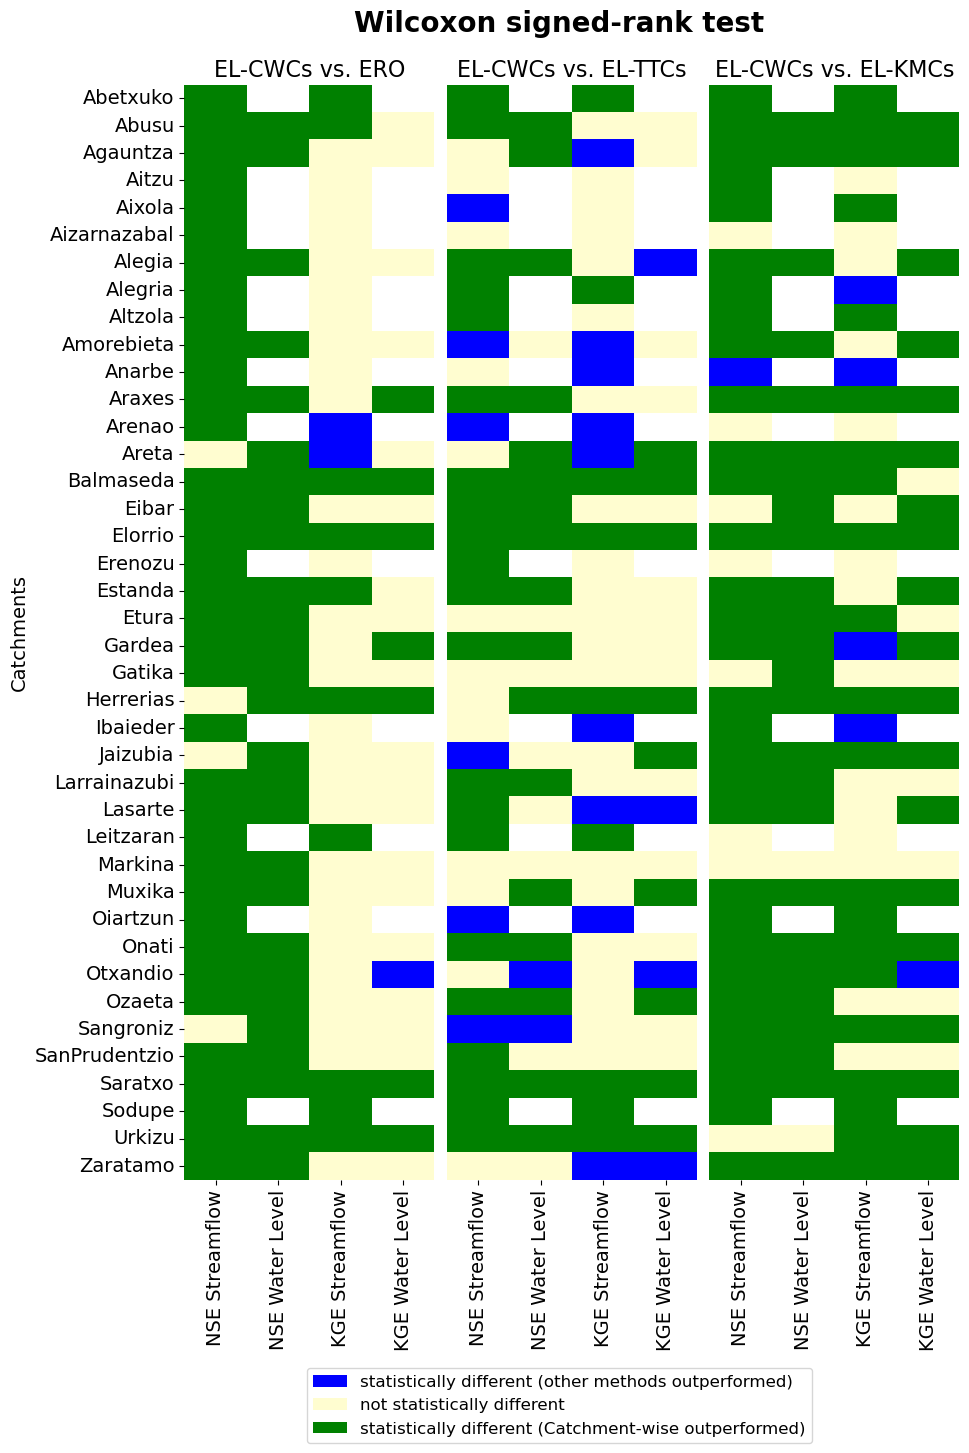

In [161]:
# 09_07 (Figure 05)

# Define the save directory
save_dir = r"...\Supplementary_materials\Figures\Stats.tests\Plots"

# Initialize the figure with 1 row and 3 columns of subplots
fig, axes = plt.subplots(1, 3, figsize=(10, 15))

# Define the legend labels and colors
legend_labels = ['statistically different (other methods outperformed)', 
                 'not statistically different', 
                 'statistically different (Catchment-wise outperformed)']
colors = ['blue', '#FFFDD0', 'green']
patches = [plt.Rectangle((0, 0), 1, 1, fc=color) for color in colors]

# Loop through the subplots
for i, (ax, (name, model01, model02, title)) in enumerate(zip(axes, [
    ('Data_Catchment_wise_vs_ERO_Wilcoxon', 'Catchment-wise', 'ERO', 'EL-CWCs vs. ERO'), 
    ('Data_Catchment_wise_vs_Top10_Wilcoxon', 'Catchment-wise', 'Top 10', 'EL-CWCs vs. EL-TTCs'),
    ('Data_Catchment_wise_vs_Kmeans_Wilcoxon', 'Catchment-wise', 'K-means', 'EL-CWCs vs. EL-KMCs')])):

    # Read the modified CSV file
    data = pd.read_excel(rf'...\Supplementary_materials\Figures\Stats.tests\Stats\{name}.xlsx', index_col='Basin')

    # Create the custom color map
    cmap = ListedColormap(colors)

    # Create the heatmap with reversed colors
    sns.heatmap(data, cmap=cmap, cbar=False, ax=ax)  # Remove the color bar

    # Customize y-label and y-ticks
    if i == 0:
        ax.set_ylabel('Catchments', fontsize=14)
    else:
        ax.set_ylabel('')
        ax.set_yticks([])  # Remove y-axis ticks

    # Customize x-ticks and titles
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels())
    ax.set_title(title, fontsize=16)

    # Set tick parameters
    ax.tick_params(axis='both', which='major', labelsize=14)

# Add a single legend for the whole figure
fig.legend(patches, legend_labels, loc='upper center', bbox_to_anchor=(0.5, 0.08), ncol=1, fontsize=12)

# Add a main title for the entire figure
fig.suptitle('Wilcoxon signed-rank test', fontsize=20, fontweight='bold')

# Adjust layout to make room for the main title and legend
plt.subplots_adjust(wspace=0.05, top=0.93, bottom=0.2)  # Adjust top and bottom for legend and title

# Save the figure
save_path_png = os.path.join(save_dir, 'Wilcoxon_stats.tiff')
plt.savefig(save_path_png, dpi=300, bbox_inches='tight')  # Use bbox_inches='tight' to include all elements

plt.show()


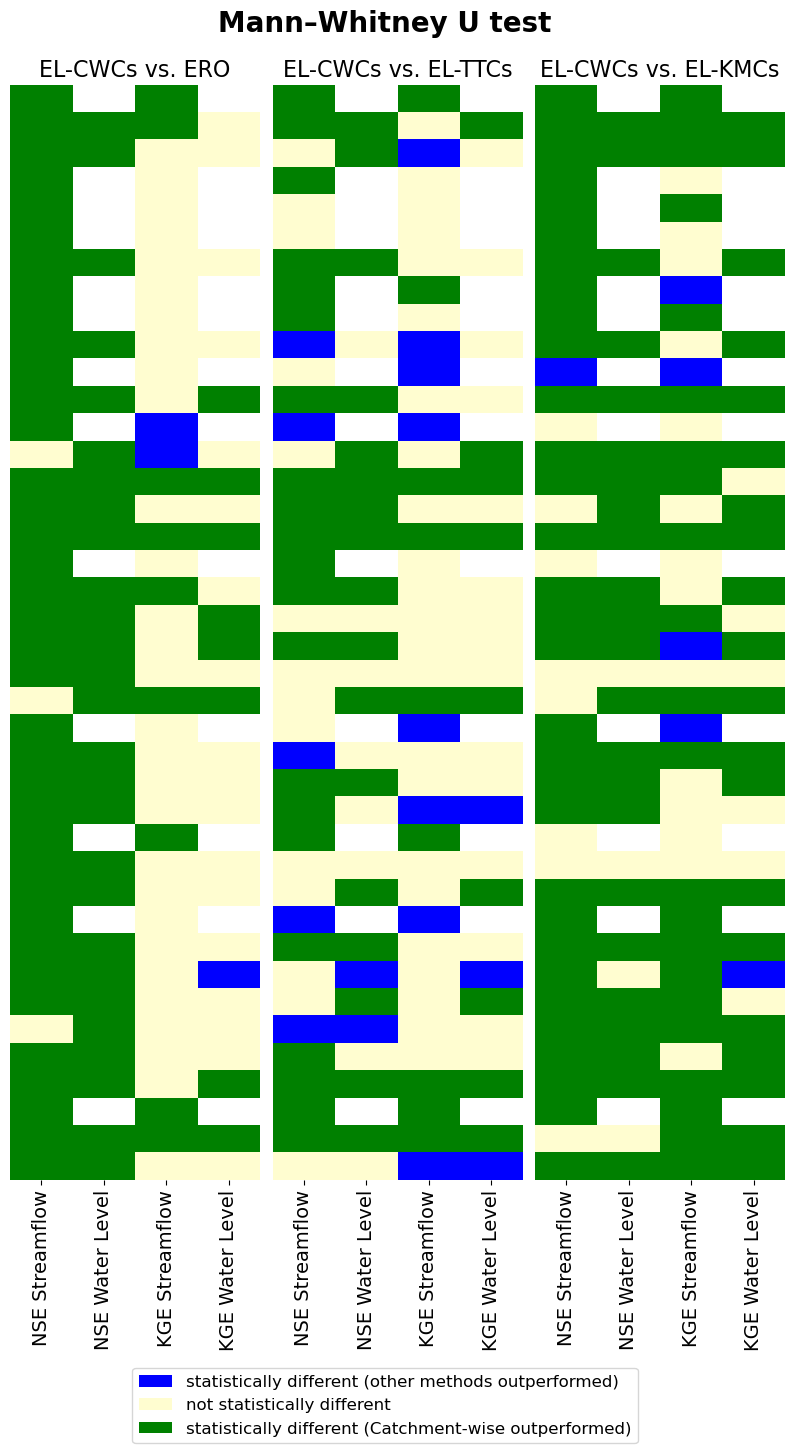

In [168]:
# 09_08 (Figure 05)

# Define the save directory
save_dir = r"...\Supplementary_materials\Figures\Stats.tests\Plots"

# Initialize the figure with 1 row and 3 columns of subplots
fig, axes = plt.subplots(1, 3, figsize=(10, 15))

# Define the legend labels and colors
legend_labels = ['statistically different (other methods outperformed)', 
                 'not statistically different', 
                 'statistically different (Catchment-wise outperformed)']
colors = ['blue', '#FFFDD0', 'green']
patches = [plt.Rectangle((0, 0), 1, 1, fc=color) for color in colors]

# Loop through the subplots
for i, (ax, (name, model01, model02, title)) in enumerate(zip(axes, [
    ('Data_Catchment_wise_vs_ERO_Mann', 'Catchment-wise', 'ERO', 'EL-CWCs vs. ERO'), 
    ('Data_Catchment_wise_vs_Top10_Mann', 'Catchment-wise', 'Top 10', 'EL-CWCs vs. EL-TTCs'),
    ('Data_Catchment_wise_vs_Kmeans_Mann', 'Catchment-wise', 'K-means', 'EL-CWCs vs. EL-KMCs')])):

    # Read the modified CSV file
    data = pd.read_excel(rf'...\Supplementary_materials\Figures\Stats.tests\Stats\{name}.xlsx', index_col='Basin')

    # Create the custom color map
    cmap = ListedColormap(colors)

    # Create the heatmap with reversed colors
    sns.heatmap(data, cmap=cmap, cbar=False, ax=ax)  # Remove the color bar

    # Customize y-label and y-ticks
    ax.set_ylabel('')
    ax.set_yticks([])  # Remove y-axis ticks

    # Customize x-ticks and titles
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels())
    ax.set_title(title, fontsize=16)

    # Set tick parameters
    ax.tick_params(axis='both', which='major', labelsize=14)

# Add a single legend for the whole figure
fig.legend(patches, legend_labels, loc='upper center', bbox_to_anchor=(0.5, 0.08), ncol=1, fontsize=12)

# Add a main title for the entire figure
fig.suptitle('Mann–Whitney U test', fontsize=20, fontweight='bold')

# Adjust layout to make room for the main title and legend
plt.subplots_adjust(wspace=0.05, top=0.93, bottom=0.2)  # Adjust top and bottom for legend and title

# Save the figure
save_path_png = os.path.join(save_dir, 'Mann_stats.tiff')
plt.savefig(save_path_png, dpi=300)

plt.show()


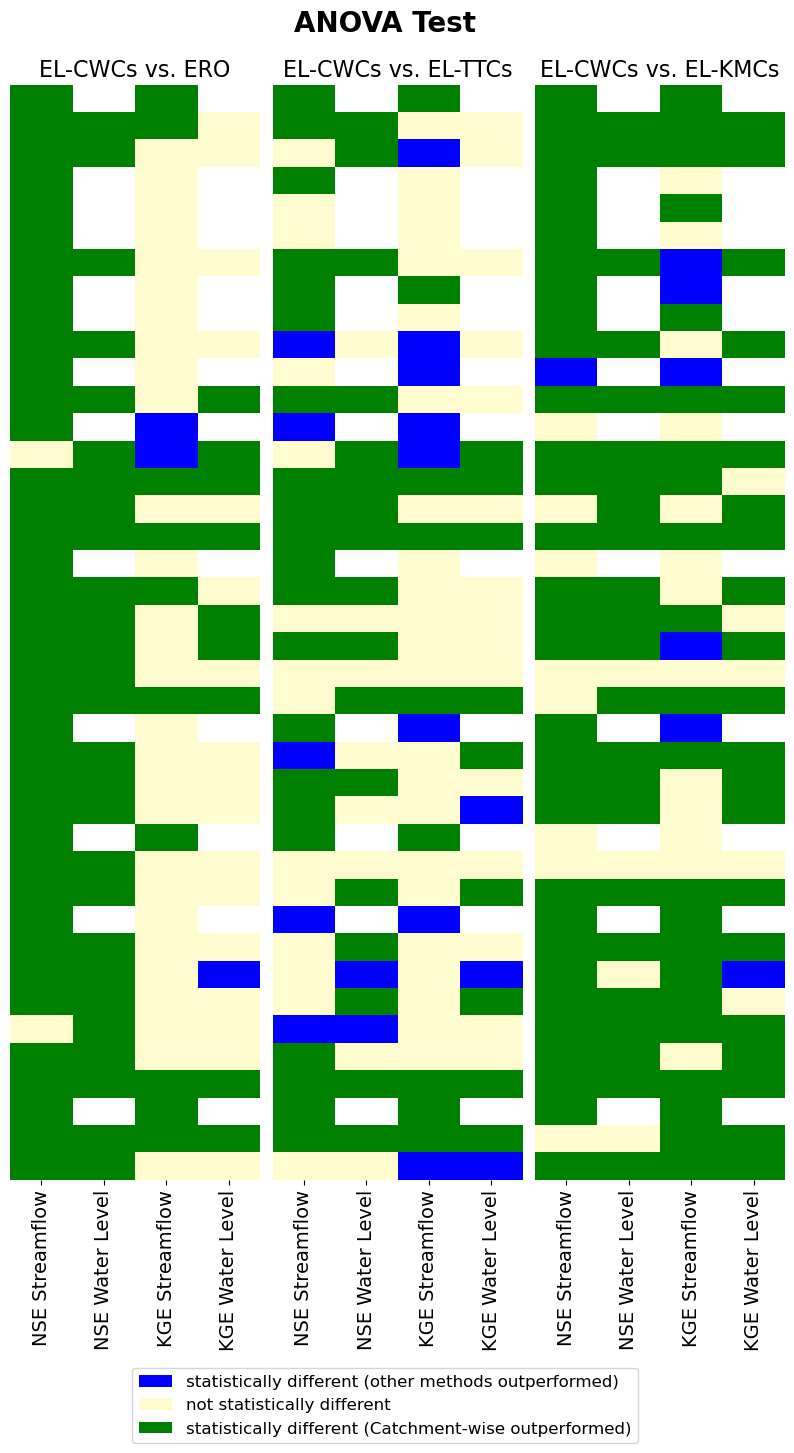

In [172]:
# 09_09 (Figure 05)

# Define the save directory
save_dir = r"...\Supplementary_materials\Figures\Stats.tests\Plots"

# Initialize the figure with 1 row and 3 columns of subplots
fig, axes = plt.subplots(1, 3, figsize=(10, 15))

# Define the legend labels and colors
legend_labels = ['statistically different (other methods outperformed)', 
                 'not statistically different', 
                 'statistically different (Catchment-wise outperformed)']
colors = ['blue', '#FFFDD0', 'green']
patches = [plt.Rectangle((0, 0), 1, 1, fc=color) for color in colors]

# Loop through the subplots
for i, (ax, (name, model01, model02, title)) in enumerate(zip(axes, [
    ('Data_Catchment_wise_vs_ERO_ANOVA', 'Catchment-wise', 'ERO', 'EL-CWCs vs. ERO'), 
    ('Data_Catchment_wise_vs_Top10_ANOVA', 'Catchment-wise', 'Top 10', 'EL-CWCs vs. EL-TTCs'),
    ('Data_Catchment_wise_vs_Kmeans_ANOVA', 'Catchment-wise', 'K-means', 'EL-CWCs vs. EL-KMCs')])):

    # Read the modified CSV file
    data = pd.read_excel(rf'...\Supplementary_materials\Figures\Stats.tests\Stats\{name}.xlsx', index_col='Basin')

    # Create the custom color map
    cmap = ListedColormap(colors)

    # Create the heatmap with reversed colors
    sns.heatmap(data, cmap=cmap, cbar=False, ax=ax)  # Remove the color bar

    ax.set_ylabel('')
    ax.set_yticks([])  # Remove y-axis ticks

    # Customize x-ticks and titles
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels())
    ax.set_title(title, fontsize=16)

    # Set tick parameters
    ax.tick_params(axis='both', which='major', labelsize=14)

# Add a single legend for the whole figure
fig.legend(patches, legend_labels, loc='upper center', bbox_to_anchor=(0.5, 0.08), ncol=1, fontsize=12)

# Add a main title for the entire figure
fig.suptitle('ANOVA Test', fontsize=20, fontweight='bold')

# Adjust layout to make room for the main title and legend
plt.subplots_adjust(wspace=0.05, top=0.93, bottom=0.2)  # Adjust top and bottom for legend and title

# Save the figure
save_path_png = os.path.join(save_dir, 'ANOVA_stats.tiff')
plt.savefig(save_path_png, dpi=300)

plt.show()


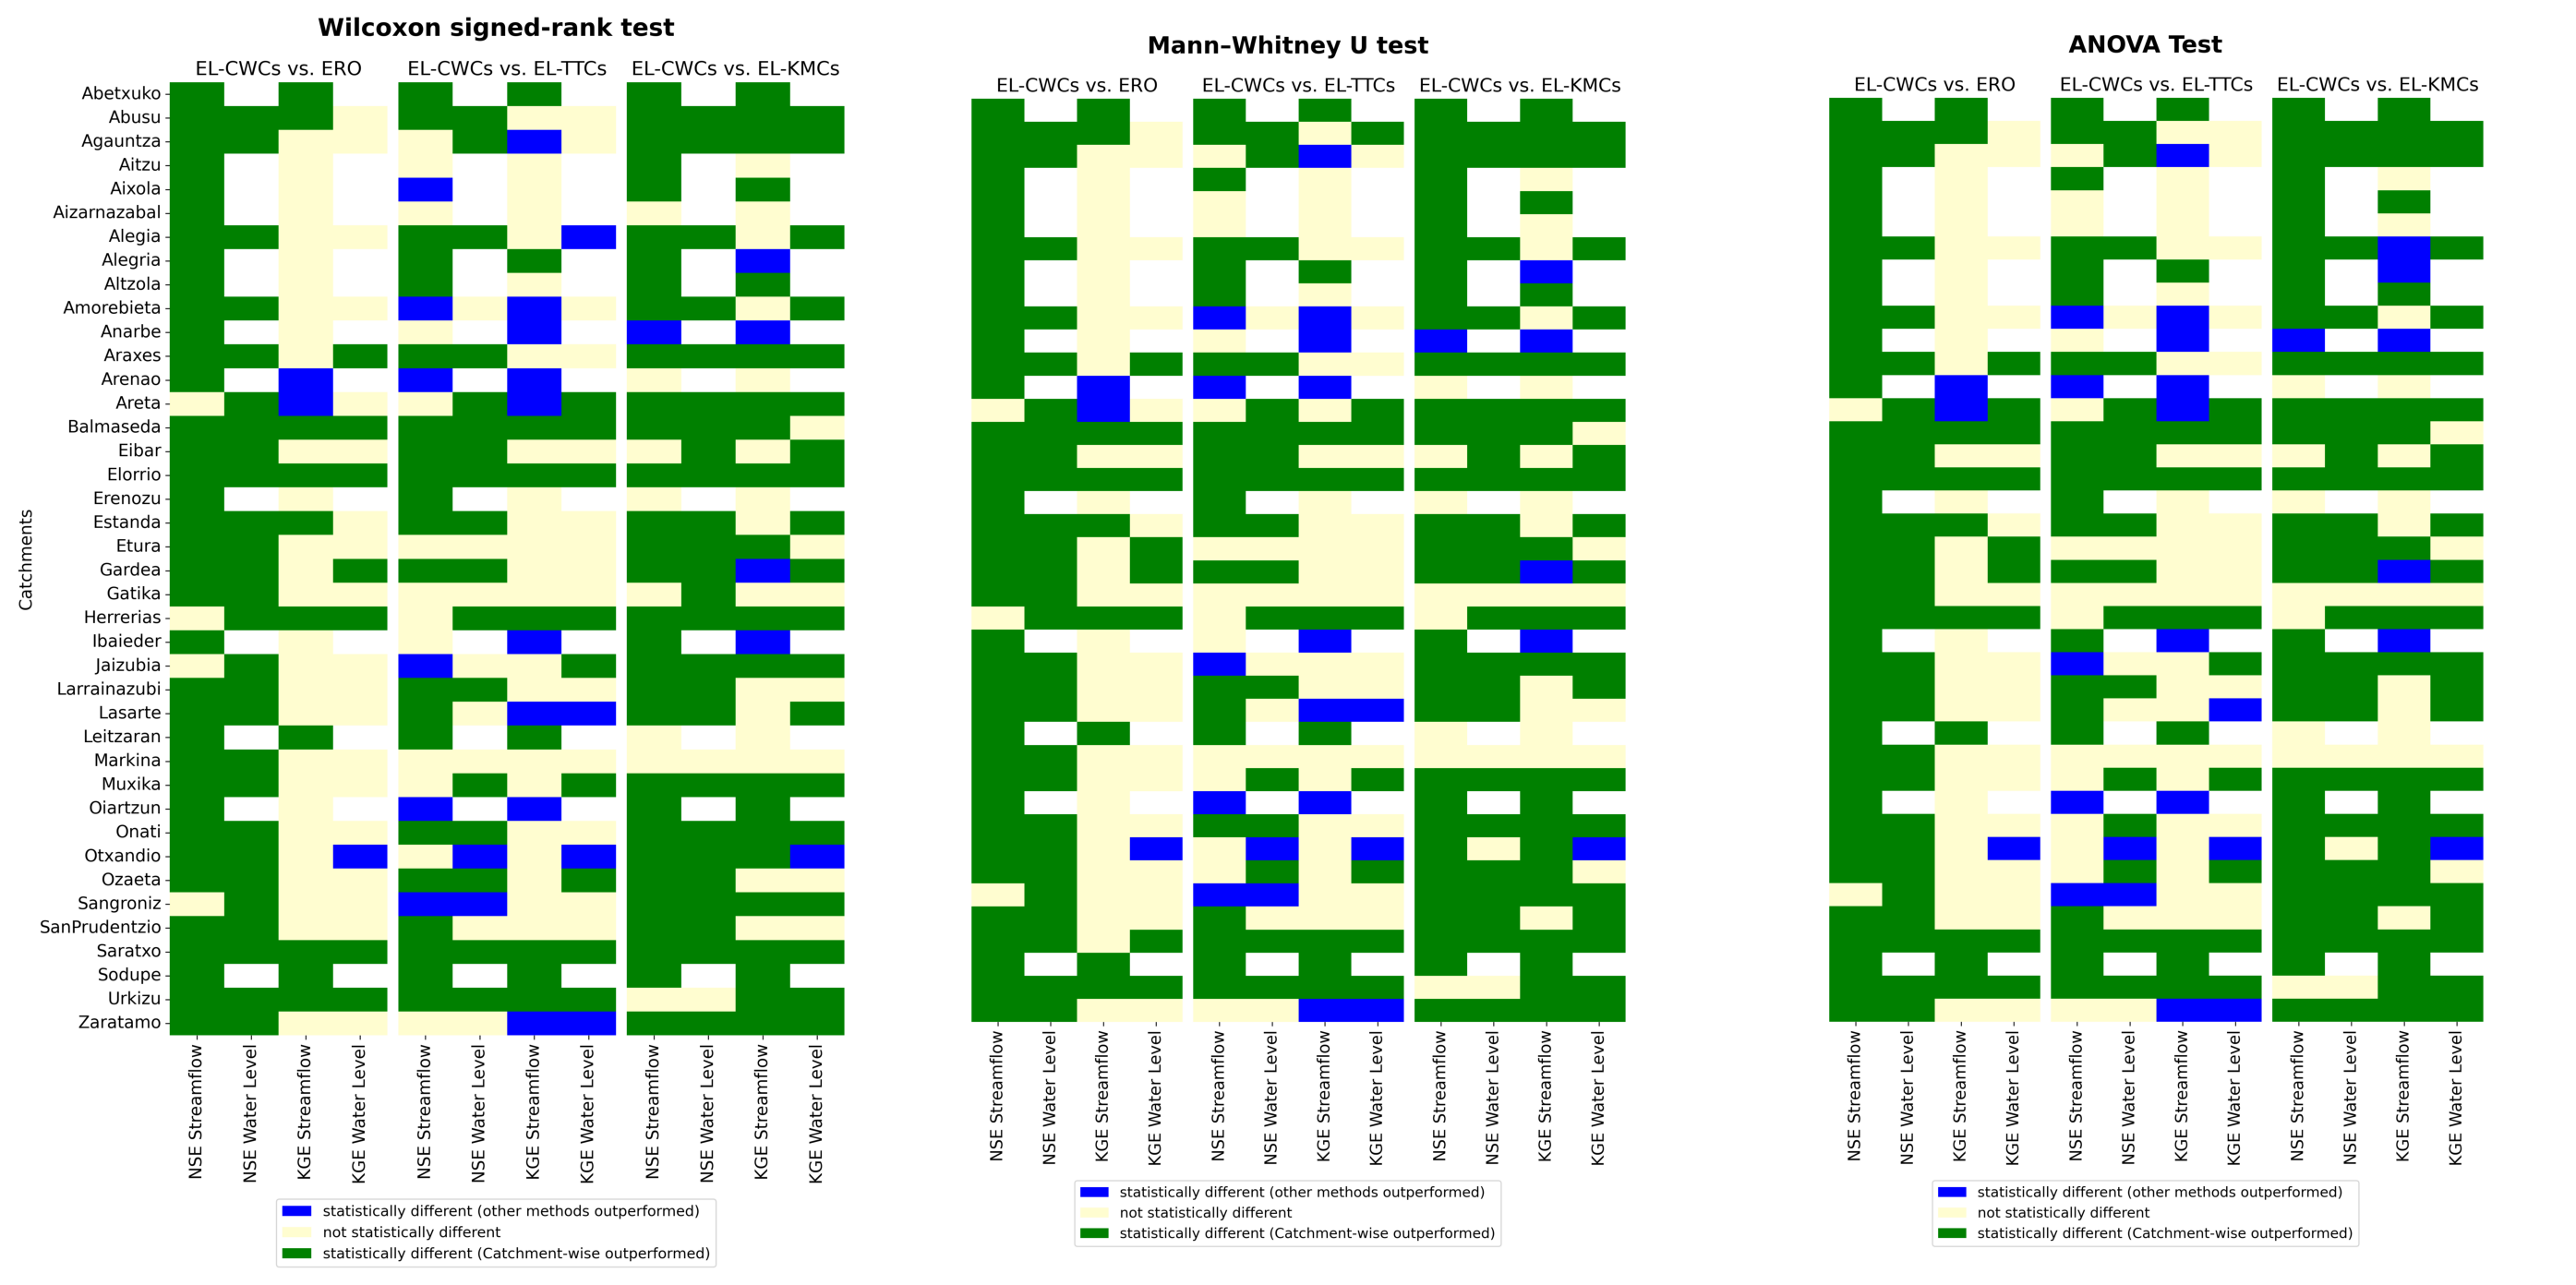

In [177]:
# 09_10 (final Figure 05)

# Define the paths to the figures
fig_paths = [
    r"...\Supplementary_materials\Figures\Stats.tests\Plots\Wilcoxon_stats.tiff",
    r"...\Supplementary_materials\Figures\Stats.tests\Plots\Mann_stats.tiff",
    r"...\Supplementary_materials\Figures\Stats.tests\Plots\ANOVA_stats.tiff"
]

# Create a 4x2 grid of subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(28, 20))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through each subplot and add the corresponding figure
for i, ax in enumerate(axes):
    img = imread(fig_paths[i])
    ax.imshow(img)
    ax.axis('off')  # Hide axis labels

# Adjust the layout to decrease space between figures
plt.subplots_adjust(wspace=0.05, hspace=0.05)

# Adjust layout to prevent overlap
plt.tight_layout()

# Define the directory to save the plots
save_dir = r"...\Supplementary_materials\Figures"

# Save the plot to a PDF file
save_path = os.path.join(save_dir, 'Figure05.pdf')
os.makedirs(os.path.dirname(save_path), exist_ok=True)  
plt.savefig(save_path, format='pdf', dpi=600)

# Save the plot to a TIFF file
save_path = os.path.join(save_dir, 'Figure05.tiff')
os.makedirs(os.path.dirname(save_path), exist_ok=True)  
plt.savefig(save_path, format='tiff', dpi=600)

# Save the plot to a PNG file
save_path = os.path.join(save_dir, 'Figure05.png')
os.makedirs(os.path.dirname(save_path), exist_ok=True) 
plt.savefig(save_path, format='tiff', dpi=300)

# Show the combined figure
plt.show()
